In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 56.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 41.7 MB/s eta 0:00:00


In [ ]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.5/164.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 49.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 52.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 46.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 18.8 MB/s eta 0:00:00


In [ ]:
!pip install scikit-learn
!pip install geopandas
!pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 MB 45.1 MB/s eta 0:00:0000:0100:01


In [ ]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import geopandas as gpd

# **Getting the Data Ready for Use!**

In [ ]:

# The following steps involve merging three datasets to get the complete taxi trip data:
# 1. `taxi_df`: The main dataset containing trip details such as pickup/dropoff locations, trip distance, and payment information.
# 2. `taxi_zones.csv`: A dataset mapping LocationID to Borough, Zone, and Service Zone, which will help contextualize pickup and dropoff locations.
# 3. `taxi_zone_shape`: A shapefile containing geometric information about taxi zones, which can be used for geospatial analysis.
# These datasets will be merged sequentially to create a unified dataset for further exploration and processing

##### **Taxi Trip Data**

In [ ]:
# Load the dataset
taxi_df = pd.read_parquet("yellow_tripdata_2019-12.parquet")

# Select only required columns to optimize memory usage and prevent potential crashes due to redundant columns.
# Airport_fee, though potentially useful, is not included as the column was not populated with data.
selected_columns = [
    'tpep_pickup_datetime', 'tpep_dropoff_datetime',
    'passenger_count', 'trip_distance',
    'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
    'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
    'total_amount', 'congestion_surcharge'
]
taxi_df = taxi_df[selected_columns]

In [ ]:
taxi_df.isnull().sum()

tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          51018
trip_distance                0
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     51018
dtype: int64

# **Handling Missing Values**

In [ ]:
taxi_df.shape

(6896317, 15)

In [ ]:
# Looking at the data, the rows from 6845299, have nulls for the columns 'passenger_count', 'congestion_surcharge
suspect_records = taxi_df.loc[6845299:6896317]

# Check missing values
missing_values = suspect_records.isnull().sum()
total_records = len(taxi_df)
suspect_records_count = len(suspect_records)

# Calculate percentage of missing records
missing_percentage = (suspect_records_count / total_records) * 100
# Print results
print(f"Number of suspect records: {suspect_records_count}")
print(f"Percentage of suspect records in the dataset: {missing_percentage:.2f}%")

Number of suspect records: 51018
Percentage of suspect records in the dataset: 0.74%


In [ ]:
# These records make up a small portion of the dataset (less than 1%) and have critical missing values in passenger_count and congestion_surcharge, so we drop them.

taxi_df = taxi_df.dropna()

# **Handling Outliers**

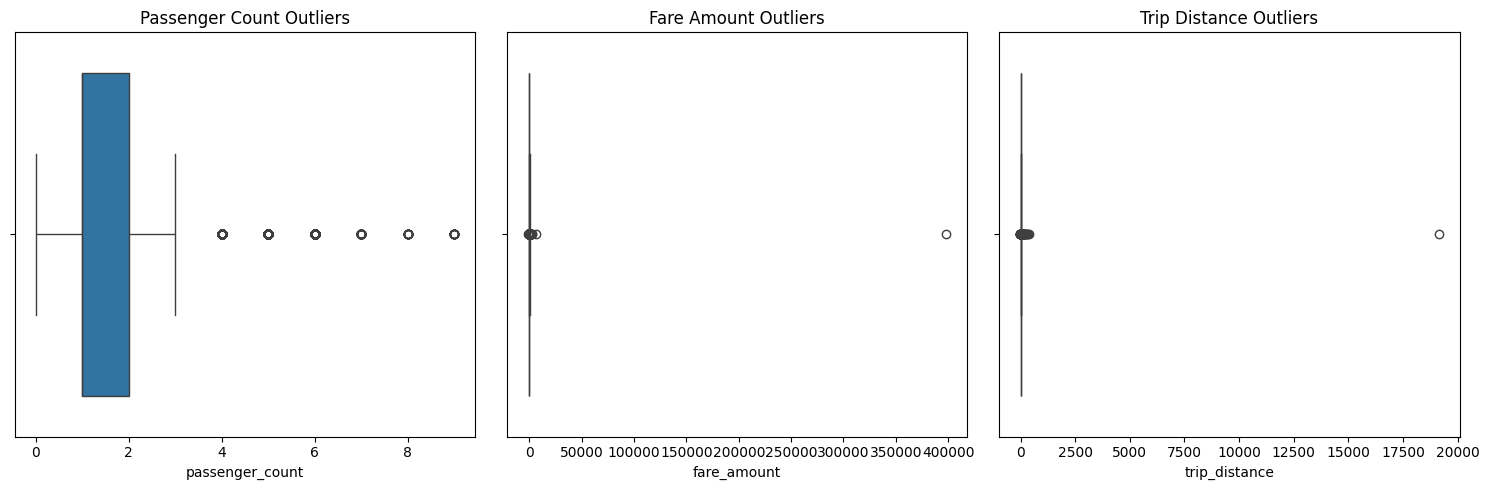

In [ ]:
"""
Firts, lets visualize the existiance of outliers in the columns 'Passenger_count', 'fare_amount' and 'trip_disstance'
Passenger count, fare amount, and trip distance are closely related, as passenger count impacts shared fares, while trip distance directly influences fare calculations,
making inconsistencies across these values indicative of data issues.
"""

plt.figure(figsize=(15, 5))

for i, col in enumerate(['passenger_count', 'fare_amount', 'trip_distance'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=taxi_df, x=col)
    plt.title(f'{col.replace("_", " ").title()} Outliers')

plt.tight_layout()
plt.show()


*Insights:*

The boxplots reveal significant outliers in the dataset across passenger count, fare amount, and trip distance. For passenger count, most trips involve 1 - 2 passengers, but outliers appear starting from 6 passengers, which represents data inaccuracies, since legally a maximum of 6 passengers can be accomodated in a taxi. The fare amount shows extreme outliers, with abnormally high values that might be caused by errors or exceptional cases like long-distance trips. Similarly, trip distance includes both extreme positive and negative outliers, where negative distances likely indicate incorrect data entries.

**Handling the outliers for the column 'Passenger Count'**

In [ ]:
taxi_df['payment_type'] = taxi_df['payment_type'].astype(int)

# Check for records where `passenger_count` is greater than 6, as these values exceed the legally allowed maximum of 6 passengers.
invalid_passenger_count = taxi_df[taxi_df['passenger_count'] > 6]
print(f"Number of invalid records where passenger count is > 6: {len(invalid_passenger_count)}")

taxi_df.loc[taxi_df['passenger_count'] > 6, 'passenger_count'] = 6
print("Invalid passenger counts have been successfully replaced with the maximum allowed value of 6.")

Number of invalid records where passenger count is > 6: 79
Invalid passenger counts have been successfully replaced with the maximum allowed value of 6.


In [ ]:
# Check for records where passenger count is < 1 when the trip distance and fare amount being invalid
invalid_fare_and_trip = taxi_df[(taxi_df['passenger_count'] < 1) &
                                 ((taxi_df['fare_amount'] < 0) | (taxi_df['trip_distance'] == 0))]

print(f"Number of records with negative fare or zero trip distance: {len(invalid_fare_and_trip)}")

taxi_df = taxi_df.drop(invalid_fare_and_trip.index)
# These are considered invalid as trips can't have zero passengers, and negative fares, or distances.

Number of records with negative fare or zero trip distance: 2146


In [ ]:
# Check for records with passenger_count < 1, with the trip distance and fare amount being valid
invalid_passenger_count = taxi_df[taxi_df['passenger_count'] < 1]
print(f"Number of invalid records before imputation: {len(invalid_passenger_count)}")

# Fill these records with nulls, and impute using linear regression considering the subclasses
taxi_df.loc[taxi_df['passenger_count'] < 1, 'passenger_count'] = None

# Select features for regression
features = ['total_amount', 'trip_distance', 'fare_amount']
X = taxi_df.dropna(subset=['passenger_count'])[features]
y = taxi_df.dropna(subset=['passenger_count'])['passenger_count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict and impute missing values
missing_idx = taxi_df['passenger_count'].isna()
taxi_df.loc[missing_idx, 'passenger_count'] = model.predict(taxi_df.loc[missing_idx, features])

# Drop any remaining invalid records (passenger_count < 1, negative fare_amount, or negative trip_distance)
taxi_df = taxi_df[(taxi_df['passenger_count'] >= 1)]
invalid_passenger_count = taxi_df[taxi_df['passenger_count'] < 1]

# Check the results
print(f"Number of invalid records after imputation: {len(invalid_passenger_count)}")

# Round the predicted values and convert to integer
taxi_df['passenger_count'] = taxi_df['passenger_count'].round().astype(int)

Number of invalid records before imputation: 123185
Number of invalid records after imputation: 0


**Handling the outliers for the column 'fare amount'**

In [ ]:
# Drop all records with payment type "No Charge" (Promotional Rides)
taxi_df = taxi_df[taxi_df['payment_type'] != 2]
# Reason: Promotional rides are excluded to focus on standard trips only.

# Filter invalid fare amount records where < $2.5
invalid_fare_amount = taxi_df[taxi_df['fare_amount'] < 2.5]

# Drop invalid records with fare amount < 2.5 and payment_type is Credit (0), Cash (1), or Voided Trip (5)
taxi_df = taxi_df[
    ~((taxi_df['fare_amount'] < 2.5) & taxi_df['payment_type'].isin([0, 1, 5]))
]
# Reason: These are invalid transactions and cannot be corrected logically.

# Impute for Unknown (4) and Dispute (3) using linear regression
valid_data = taxi_df[taxi_df['fare_amount'] >= 2.5]
X_train = valid_data[['trip_distance', 'passenger_count']]
y_train = valid_data['fare_amount']
model = LinearRegression().fit(X_train, y_train)

# Impute invalid fare amounts
to_impute = invalid_fare_amount[invalid_fare_amount['payment_type'].isin([3, 4])]
X_to_impute = to_impute[['trip_distance', 'passenger_count']]
predicted_fares = model.predict(X_to_impute)

# Update fare_amount in the original dataset
taxi_df.loc[to_impute.index, 'fare_amount'] = predicted_fares

In [ ]:
# Filter invalid fare amount records where fare_amount > $150
high_fare_data = taxi_df[taxi_df['fare_amount'] > 150]

# Drop invalid records where payment_type is Cash (1)
taxi_df = taxi_df[
    ~((taxi_df['fare_amount'] > 150) & (taxi_df['payment_type'] == 1))]
# Reason: High cash payments are considered outliers or unfixable errors.

# Impute for Dispute (3), and Unknown (4) using linear regression
valid_data = taxi_df[taxi_df['fare_amount'] <= 150]
X_train = valid_data[['trip_distance', 'passenger_count']]
y_train = valid_data['fare_amount']
model = LinearRegression().fit(X_train, y_train)
to_impute = high_fare_data[high_fare_data['payment_type'].isin([3, 4])]
X_to_impute = to_impute[['trip_distance', 'passenger_count']]
predicted_fares = model.predict(X_to_impute)

# Update fare_amount for imputed records
taxi_df.loc[to_impute.index, 'fare_amount'] = predicted_fares

# Impute any remaining fare amounts above 150 to $150
taxi_df.loc[taxi_df['fare_amount'] > 150, 'fare_amount'] = 150

**Handling the outliers for 'trip dates'**

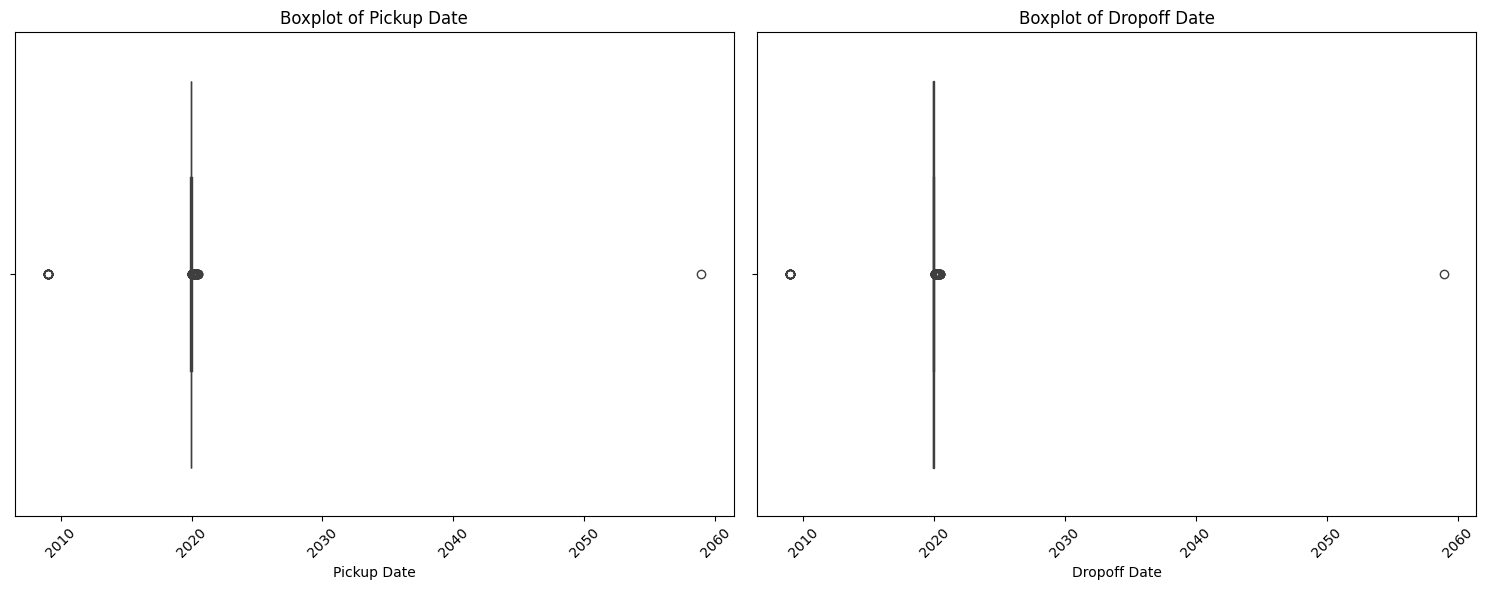

In [ ]:
# Convert datetime to date for simplified visualization
taxi_df['pickup_date'] = taxi_df['tpep_pickup_datetime'].dt.date
taxi_df['dropoff_date'] = taxi_df['tpep_dropoff_datetime'].dt.date

# Create boxplots for pickup and drop-off dates
plt.figure(figsize=(15, 6))
for i, col in enumerate(['pickup_date', 'dropoff_date'], 1):
    plt.subplot(1, 2, i)
    sns.boxplot(x=taxi_df[col])
    plt.title(f'Boxplot of {col.replace("_", " ").title()}')
    plt.xlabel(col.replace('_', ' ').title())
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Define the valid date range
valid_start_date = pd.Timestamp("2019-12-01")
valid_end_date = pd.Timestamp("2019-12-31")

# Filter out records with pickup or drop-off dates outside the valid range
taxi_df = taxi_df[
    (taxi_df['tpep_pickup_datetime'] >= valid_start_date) &
    (taxi_df['tpep_dropoff_datetime'] <= valid_end_date)
]

print(f"Number of records after dropping out-of-range dates: {len(taxi_df)}")

Number of records after dropping out-of-range dates: 4818513


**Handling the outliers for 'trip duration'**

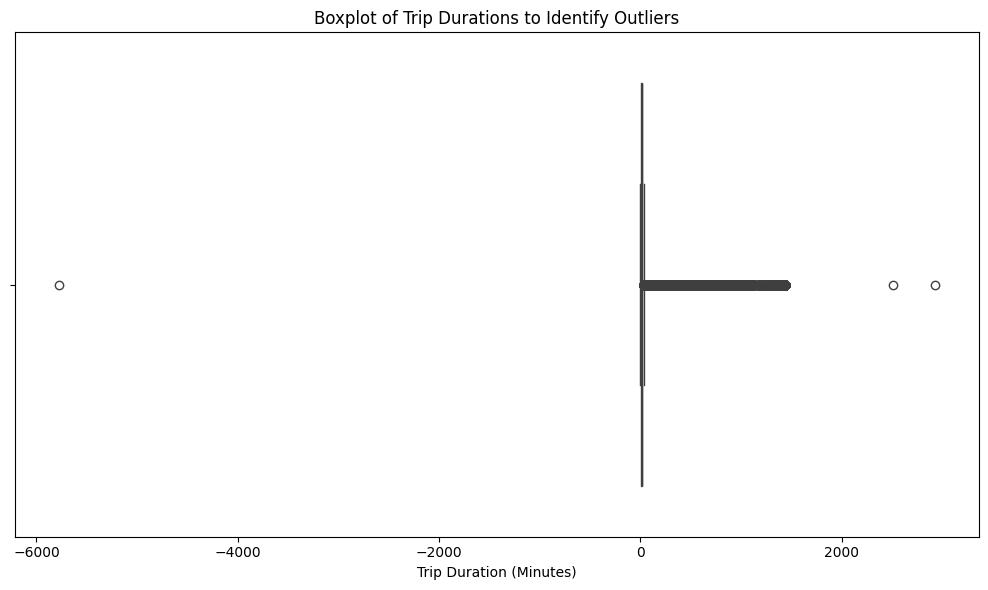

In [ ]:
# Calculate trip duration in minutes
taxi_df['trip_duration_minutes'] = (
    (taxi_df['tpep_dropoff_datetime'] - taxi_df['tpep_pickup_datetime']).dt.total_seconds() / 60
)

# Plot the boxplot for trip duration
plt.figure(figsize=(10, 6))
sns.boxplot(x=taxi_df['trip_duration_minutes'])
plt.title('Boxplot of Trip Durations to Identify Outliers')
plt.xlabel('Trip Duration (Minutes)')
plt.tight_layout()
plt.show()


In [ ]:
# The boxplot shows significant outliers with negative and extremely high trip durations, indicating invalid or incorrectly recorded trips.
# Let us consider the valid trip duration to be above 1min and below 180min

invalid_duration_data = taxi_df[
    (taxi_df['trip_duration_minutes'] <= 1) |
    (taxi_df['trip_duration_minutes'] >= 180)
]
print(f"Number of trips with invalid duration: {len(invalid_duration_data)}")

Number of trips with invalid duration: 52565


In [ ]:
# Fill invalid durations with NaN for imputation
taxi_df.loc[
    (taxi_df['trip_duration_minutes'] <= 1) | (taxi_df['trip_duration_minutes'] >= 180),
    'trip_duration_minutes'
] = None

# Group by pickup and dropoff location IDs to calculate mean trip duration
location_duration_means = taxi_df.groupby(['PULocationID', 'DOLocationID'])['trip_duration_minutes'].mean()

# Impute invalid trip durations with mean duration for the same pickup-dropoff location
for index, row in taxi_df[taxi_df['trip_duration_minutes'].isna()].iterrows():
    pu_id = row['PULocationID']
    do_id = row['DOLocationID']
    mean_duration = location_duration_means.get((pu_id, do_id), None)
    if mean_duration is not None:
        taxi_df.loc[index, 'trip_duration_minutes'] = mean_duration

print(f"Number of remaining NaN trip durations after imputation: {taxi_df['trip_duration_minutes'].isna().sum()}")

# Drop remaining records with NaN trip durations
taxi_df = taxi_df.dropna(subset=['trip_duration_minutes'])
taxi_df = taxi_df.drop(columns=['trip_duration_minutes'])
print(f"Total number of records after imputation: {len(taxi_df)}")

Number of remaining NaN trip durations after imputation: 221
Total number of records after imputation: 4818292


# **Merging the Datasets**

In [ ]:
taxi_zone_lkup_csv = pd.read_csv("taxi_zone_lookup.csv")

In [ ]:
taxi_zone_lkup_csv.columns

Index(['LocationID', 'Borough', 'Zone', 'service_zone'], dtype='object')

In [ ]:
# Find the LocationID where service_zone is null
null_service_zone_location_ids = taxi_zone_lkup_csv[taxi_zone_lkup_csv['service_zone'].isnull()]['LocationID']

# Display the LocationIDs
print(null_service_zone_location_ids)

263    264
264    265
Name: LocationID, dtype: int64


In [ ]:
taxi_zone_lkup_csv.dropna(inplace=True)

**Verify the data validity column; Drop LocationIDs 264 and 265 from trip_data**

In [ ]:
# Drop rows where PULocationID or DOLocationID are 264 or 265 since these are no service zones
taxi_df = taxi_df[~taxi_df['PULocationID'].isin([264, 265]) & ~taxi_df['DOLocationID'].isin([264, 265])]

In [ ]:
taxi_df.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge',
       'pickup_date', 'dropoff_date'],
      dtype='object')

**Load Taxi Zone Shape File**

In [ ]:
import os
os.environ["SHAPE_RESTORE_SHX"] = "YES"

In [ ]:
taxi_zone_gdf = gpd.read_file("taxi_zones.shp")

In [ ]:
taxi_zone_gdf.set_crs("EPSG:2263", inplace=True)

# Reproject to WGS84 (latitude and longitude)
taxi_zone_gdf = taxi_zone_gdf.to_crs("EPSG:4326")

# Check the reprojected data
print(taxi_zone_gdf.head())

                                            geometry
0  POLYGON ((-74.18445 40.695, -74.18449 40.6951,...
1  MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...
2  POLYGON ((-73.84793 40.87134, -73.84725 40.870...
3  POLYGON ((-73.97177 40.72582, -73.97179 40.725...
4  POLYGON ((-74.17422 40.56257, -74.17349 40.562...


In [ ]:
taxi_zone_gdf['ID'] = range(1, len(taxi_zone_gdf) + 1)

In [ ]:
taxi_zone_gdf.head(2)

,geometry,ID
0,"POLYGON ((-74.18445 40.695, -74.18449 40.6951,...",1
1,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",2


**Merge Taxi Zone df + gdf**

In [ ]:
# Merge DataFrames
taxi_zone_data_with_geom = taxi_zone_gdf.merge(taxi_zone_lkup_csv, left_on='ID', right_on='LocationID', how='left')

# Convert to GeoDataFrame
taxi_zone_data_with_geom = gpd.GeoDataFrame(taxi_zone_data_with_geom, geometry='geometry')

print("Do 'ID' and 'LocationID' match for all rows?", (taxi_zone_data_with_geom['ID'] == taxi_zone_data_with_geom['LocationID']).all())

Do 'ID' and 'LocationID' match for all rows? True


In [ ]:
taxi_zone_data_with_geom.head(2)

,geometry,ID,LocationID,Borough,Zone,service_zone
0,"POLYGON ((-74.18445 40.695, -74.18449 40.6951,...",1,1,EWR,Newark Airport,EWR
1,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",2,2,Queens,Jamaica Bay,Boro Zone


**Merge Taxi Trip + Taxi Zone**

In [ ]:
taxi_df.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge',
       'pickup_date', 'dropoff_date'],
      dtype='object')

In [ ]:
taxi_zone_data_with_geom.columns

Index(['geometry', 'ID', 'LocationID', 'Borough', 'Zone', 'service_zone'], dtype='object')

In [ ]:
taxi_zone_data_with_geom.head(5)

,geometry,ID,LocationID,Borough,Zone,service_zone
0,"POLYGON ((-74.18445 40.695, -74.18449 40.6951,...",1,1,EWR,Newark Airport,EWR
1,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",2,2,Queens,Jamaica Bay,Boro Zone
2,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",3,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",4,4,Manhattan,Alphabet City,Yellow Zone
4,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",5,5,Staten Island,Arden Heights,Boro Zone


In [ ]:
# Ensure matching datatypes
taxi_df['PULocationID'] = taxi_df['PULocationID'].astype(int)
taxi_df['DOLocationID'] = taxi_df['DOLocationID'].astype(int)
taxi_zone_data_with_geom['LocationID'] = taxi_zone_data_with_geom['LocationID'].astype(int)

In [ ]:
# Merge to add pickup location details (geometry, Zone, Borough, service_zone)
trip_data_with_pickup = taxi_df.merge(
    taxi_zone_data_with_geom[['LocationID', 'geometry', 'Zone', 'Borough', 'service_zone']].rename(
        columns={'geometry': 'pickup_geom', 'Zone': 'pickup_zone', 'Borough': 'pickup_borough', 'service_zone': 'pickup_service_zone'}
    ),
    left_on='PULocationID',
    right_on='LocationID',
    how='left'
).drop(columns=['LocationID'])

# Merge to add drop-off location details (geometry, Zone, Borough, service_zone)
trip_data_with_geom = trip_data_with_pickup.merge(
    taxi_zone_data_with_geom[['LocationID', 'geometry', 'Zone', 'Borough', 'service_zone']].rename(
        columns={'geometry': 'dropoff_geom', 'Zone': 'dropoff_zone', 'Borough': 'dropoff_borough', 'service_zone': 'dropoff_service_zone'}
    ),
    left_on='DOLocationID',
    right_on='LocationID',
    how='left'
).drop(columns=['LocationID'])

# Display the final DataFrame
trip_data_with_geom.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,...,pickup_date,dropoff_date,pickup_geom,pickup_zone,pickup_borough,pickup_service_zone,dropoff_geom,dropoff_zone,dropoff_borough,dropoff_service_zone
0,2019-12-01 00:12:03,2019-12-01 00:33:19,2,9.4,138,25,1,28.5,0.5,0.5,...,2019-12-01,2019-12-01,"MULTIPOLYGON (((-73.87125 40.78604, -73.86978 ...",LaGuardia Airport,Queens,Airports,"POLYGON ((-73.98155 40.68915, -73.98102 40.688...",Boerum Hill,Brooklyn,Boro Zone
1,2019-12-01 00:29:35,2019-12-01 00:32:29,2,0.5,79,224,1,4.0,3.0,0.5,...,2019-12-01,2019-12-01,"POLYGON ((-73.98378 40.72154, -73.98382 40.721...",East Village,Manhattan,Yellow Zone,"POLYGON ((-73.97511 40.73539, -73.97496 40.735...",Stuy Town/Peter Cooper Village,Manhattan,Yellow Zone
2,2019-12-01 00:19:48,2019-12-01 00:24:18,1,0.9,148,4,1,5.5,3.0,0.5,...,2019-12-01,2019-12-01,"POLYGON ((-73.98448 40.72023, -73.98507 40.719...",Lower East Side,Manhattan,Yellow Zone,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",Alphabet City,Manhattan,Yellow Zone
3,2019-12-01 00:36:16,2019-12-01 00:53:42,3,5.5,79,226,1,18.0,3.0,0.5,...,2019-12-01,2019-12-01,"POLYGON ((-73.98378 40.72154, -73.98382 40.721...",East Village,Manhattan,Yellow Zone,"POLYGON ((-73.9099 40.74909, -73.91016 40.7485...",Sunnyside,Queens,Boro Zone
4,2019-12-01 00:04:40,2019-12-01 00:31:27,2,17.4,132,141,1,52.0,2.5,0.5,...,2019-12-01,2019-12-01,"MULTIPOLYGON (((-73.82503 40.66358, -73.82486 ...",JFK Airport,Queens,Airports,"POLYGON ((-73.96178 40.75988, -73.96197 40.759...",Lenox Hill West,Manhattan,Yellow Zone


In [ ]:
trip_data_with_geom.shape

(4764268, 25)

In [ ]:
trip_data_with_geom.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type',
       'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount', 'congestion_surcharge',
       'pickup_date', 'dropoff_date', 'pickup_geom', 'pickup_zone',
       'pickup_borough', 'pickup_service_zone', 'dropoff_geom', 'dropoff_zone',
       'dropoff_borough', 'dropoff_service_zone'],
      dtype='object')

**Handling outliers for the column 'trip_distance'**

In [ ]:
# Filter rows where trip_distance is less than 0 and greater than 100
invalid_trip_distance = trip_data_with_geom[(trip_data_with_geom['trip_distance'] > 100) | (trip_data_with_geom['trip_distance'] < 0)]

# Get distinct pickup and dropoff boroughs for these trips
pickup_boroughs = invalid_trip_distance['pickup_borough'].dropna().unique()
dropoff_boroughs = invalid_trip_distance['dropoff_borough'].dropna().unique()

# Print the distinct boroughs
print("Distinct Pickup Boroughs with invalid trip distances:")
print(pickup_boroughs)

print("\nDistinct Dropoff Boroughs with invalid trip distances:")
print(dropoff_boroughs)
print()
print("Total number of invalid distance trips: ", len(invalid_trip_distance))

Distinct Pickup Boroughs with invalid trip distances:
['Queens' 'Manhattan' 'Brooklyn']

Distinct Dropoff Boroughs with invalid trip distances:
['Queens' 'Manhattan' 'Brooklyn']

Total number of invalid distance trips:  28


In [ ]:
# Having distinct pickup and dropoff boroughs with invalid trip distances indicates that data issues span across all NYC boroughs.
# Fill invalid distances with NaN for imputation
trip_data_with_geom.loc[invalid_trip_distance.index, 'trip_distance'] = None

# Group by pickup and dropoff location IDs to calculate mean trip distance
location_means = trip_data_with_geom.groupby(['PULocationID', 'DOLocationID'])['trip_distance'].mean()

# Impute invalid trip distances with mean distance for the same pickup-dropoff location
for index, row in invalid_trip_distance.iterrows():
    pu_id = row['PULocationID']
    do_id = row['DOLocationID']
    mean_distance = location_means.get((pu_id, do_id), None)
    if mean_distance is not None:
        trip_data_with_geom.loc[index, 'trip_distance'] = mean_distance

# Print updated statistics
print(f"Number of remaining NaN trip distances after imputation: {trip_data_with_geom['trip_distance'].isna().sum()}")
# Drop remaining rows with NaN trip distances
trip_data_with_geom = trip_data_with_geom.dropna(subset=['trip_distance'])

print(f"Total number of records after imputation: {len(trip_data_with_geom)}")


Number of remaining NaN trip distances after imputation: 1
Total number of records after imputation: 4764267


# **Feature Engineering**

In [ ]:
data = trip_data_with_geom.copy()

**Create column 'trip_duration'**

In [ ]:
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])

# Calculate trip duration in minutes
data['trip_duration_minutes'] = (
    (data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds() / 60
)

# Preview the dataset with the new column
print(data[['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_duration_minutes']].head())

  tpep_pickup_datetime tpep_dropoff_datetime  trip_duration_minutes
0  2019-12-01 00:12:03   2019-12-01 00:33:19              21.266667
1  2019-12-01 00:29:35   2019-12-01 00:32:29               2.900000
2  2019-12-01 00:19:48   2019-12-01 00:24:18               4.500000
3  2019-12-01 00:36:16   2019-12-01 00:53:42              17.433333
4  2019-12-01 00:04:40   2019-12-01 00:31:27              26.783333


**Create a column 'day_type'**

In [ ]:
# Trips are categorized as holidays, weekends, or workdays to analyze travel patterns and their impact on fares and durations
cal = calendar()
holidays = cal.holidays(start='2019-12-01', end='2019-12-31')

# Add columns for day type categorization
data['holiday'] = data['tpep_pickup_datetime'].dt.date.isin(holidays)
data['week'] = data['tpep_pickup_datetime'].dt.dayofweek
data.loc[data['week'] >= 5, 'day_type'] = "weekend"
data.loc[data['week'] < 5, 'day_type'] = "workday"
data.loc[data['holiday'] == True, 'day_type'] = "holiday"
data = data.drop(['holiday', 'week'], axis=1)

**Create columns 'pickup_hour', 'dropoff_hour'**

In [ ]:
# These columns are created for its use in modeling and EDA
data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
data['dropoff_hour'] = data['tpep_dropoff_datetime'].dt.hour

**Get latitides and longitudes for locations**

In [ ]:
# Compute centroids for pickup and drop-off locations
data['pickup_centroid'] = data['pickup_geom'].apply(lambda poly: poly.centroid)
data['dropoff_centroid'] = data['dropoff_geom'].apply(lambda poly: poly.centroid)

# Extract latitude and longitude from centroids
data['pickup_lat'] = data['pickup_centroid'].apply(lambda point: point.y)
data['pickup_long'] = data['pickup_centroid'].apply(lambda point: point.x)
data['dropoff_lat'] = data['dropoff_centroid'].apply(lambda point: point.y)
data['dropoff_long'] = data['dropoff_centroid'].apply(lambda point: point.x)

# View results
print(data[['pickup_lat', 'pickup_long', 'dropoff_lat', 'dropoff_long']])

         pickup_lat  pickup_long  dropoff_lat  dropoff_long
0         40.774376   -73.873629    40.685634    -73.986114
1         40.727620   -73.985937    40.731821    -73.976598
2         40.718938   -73.990896    40.723752    -73.976968
3         40.727620   -73.985937    40.737699    -73.924673
4         40.646985   -73.786533    40.766948    -73.959635
...             ...          ...          ...           ...
4764263   40.740337   -73.990458    40.732579    -73.994305
4764264   40.740439   -73.976495    40.747746    -73.978492
4764265   40.736824   -73.984052    40.778766    -73.951010
4764266   40.740439   -73.976495    40.753309    -74.004015
4764267   40.760314   -73.941997    40.760314    -73.941997

[4764267 rows x 4 columns]


In [ ]:
data.drop(['pickup_geom', 'dropoff_geom'], axis=1, inplace=True)
data.drop(['pickup_centroid', 'dropoff_centroid'], axis=1, inplace=True)
data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1, inplace=True)

**Save the cleaned dataset**

In [ ]:
data.to_parquet('cleaned_taxi_trip_data.parquet', index=False)

**Load the cleaned dataset**

In [ ]:
data = pd.read_parquet("cleaned_taxi_trip_data.parquet")
data.columns

Index(['passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'pickup_date', 'dropoff_date', 'pickup_zone',
       'pickup_borough', 'pickup_service_zone', 'dropoff_zone',
       'dropoff_borough', 'dropoff_service_zone', 'trip_duration_minutes',
       'day_type', 'pickup_hour', 'dropoff_hour', 'pickup_lat', 'pickup_long',
       'dropoff_lat', 'dropoff_long'],
      dtype='object')

# **Exploratory Data Analysis - I**



*   EDA I focuses on analyzing general and expected trends, such as trip distances, durations, passenger counts, payment types, and fare distributions, while EDA II explores unexpected or hidden patterns, including anomalies
*   The aim of this trip analysis is to propose bus service recommendations by identifying areas with high taxi demand and inadequate bus coverage, promoting equity in transportation for underserved regions.
*   The trip data will be merged with the bus routes dataset which has geomoetry coordinates for the routes in Multistring format.
*   The trip data does not have pickup and dropoff geometry columns needed to merge with bus routes data, so these geometries will be retrieved from the taxi data shapefile.






**Trip volume analysis - Daily and Hourly Trends**

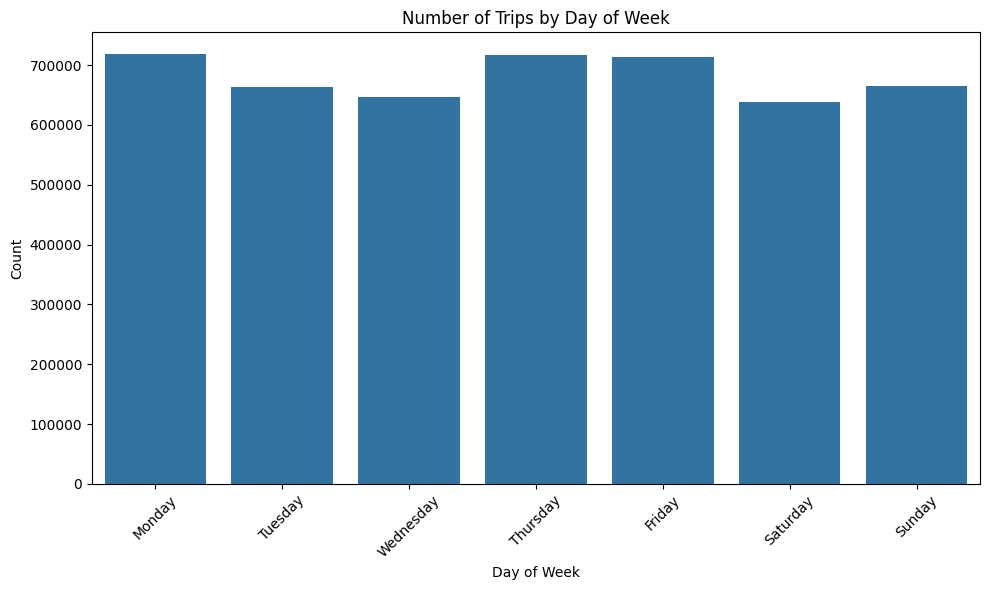

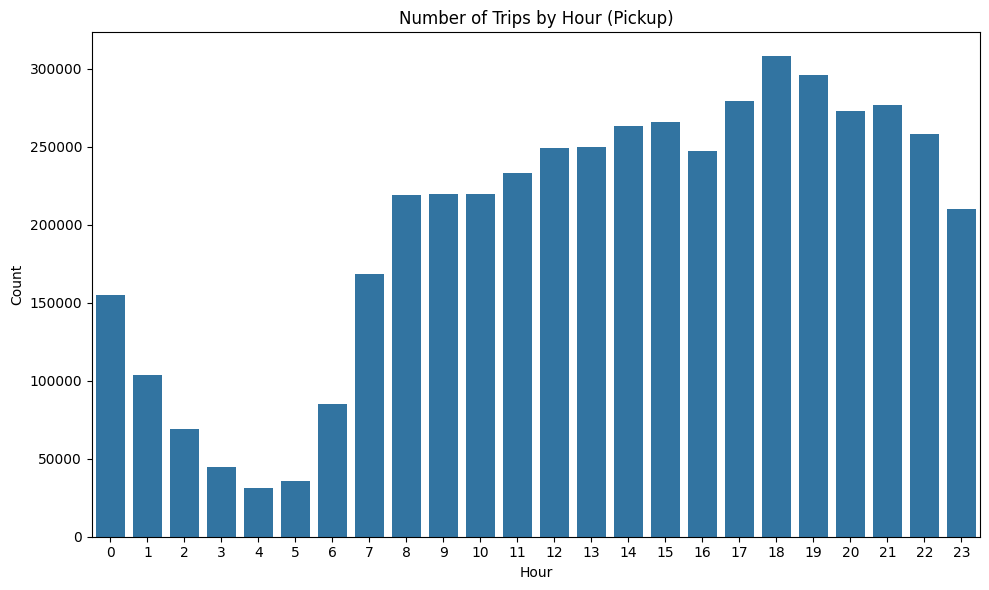

In [ ]:
data['pickup_date'] = pd.to_datetime(data['pickup_date'])

# Extract weekday and hour
data['weekday'] = data['pickup_date'].dt.day_name()

plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='weekday', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title("Number of Trips by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pickup Hourly plot
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='pickup_hour')
plt.title("Number of Trips by Hour (Pickup)")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



Taxi trips peak on Mondays and during late afternoons around 6 PM, highlighting increased commuting demand at the start of the week and evening hours, suggesting a need for enhanced transit services during these times.

**Borough-Level Trip Analysis**

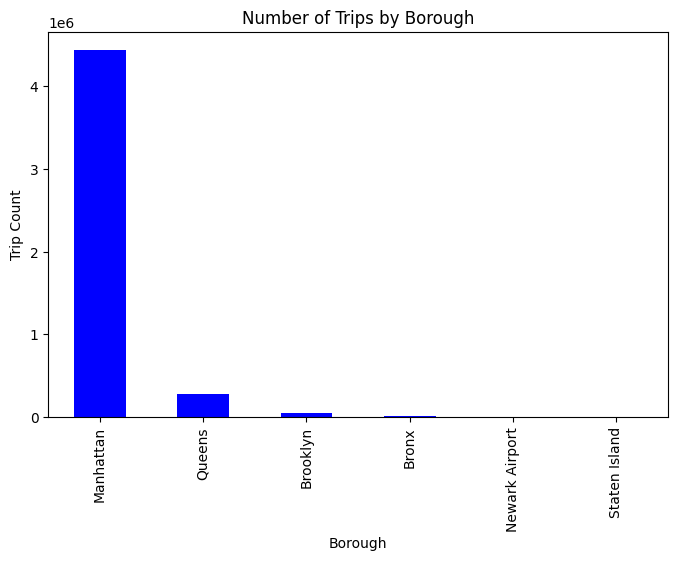

In [ ]:
"""
The borough name "EWR" corresponds to Newark Liberty International Airport. Replacing it with "Newark Airport" provides better clarity and aligns the naming convention with common understandin
"""

# Replace 'EWR' with 'Newark Airport' in both pickup and dropoff borough columns
data['pickup_borough'] = data['pickup_borough'].replace('EWR', 'Newark Airport')
data['dropoff_borough'] = data['dropoff_borough'].replace('EWR', 'Newark Airport')

# Count trips by borough
borough_trip_counts = data['pickup_borough'].value_counts()

# Plot borough trip counts
plt.figure(figsize=(8, 5))
borough_trip_counts.plot(kind='bar', color='blue')
plt.title("Number of Trips by Borough")
plt.xlabel("Borough")
plt.ylabel("Trip Count")
plt.show()

The above graph highlights that Manhattan dominates the taxi trip volume. Queens has a moderate number of trips, while Brooklyn, Bronx, Newark Airport, and Staten Island show relatively low demand. This distribution reflects Manhattan's role as the city's commercial and tourism hub.

**Distance and Fare Patterns by Borough**

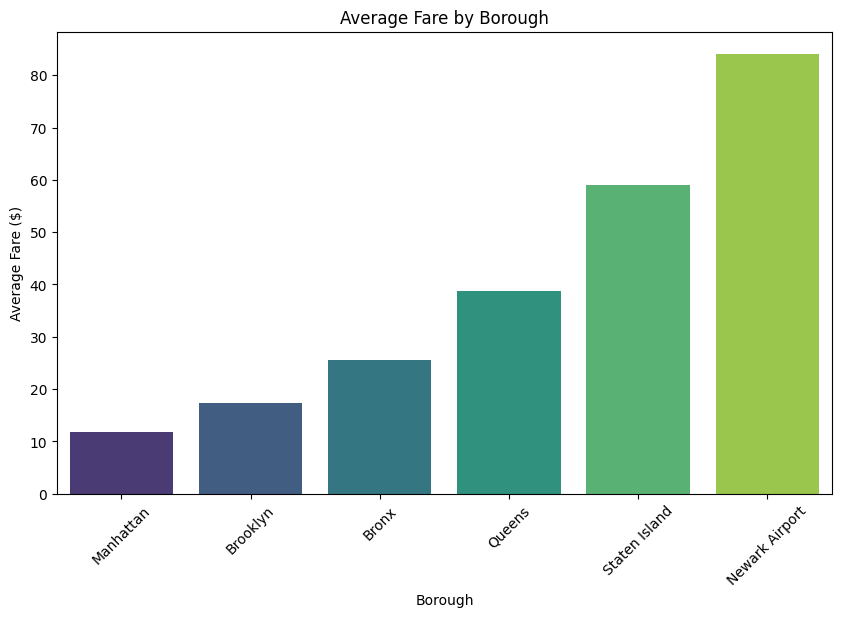

In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')


# Calculate average trip distance and fare per borough
distance_fare_stats_borough = (
    data.groupby('pickup_borough')[['trip_distance', 'fare_amount']]
    .mean()
    .reset_index()
)

# Sort data by average fare for plotting
distance_fare_stats_borough_sorted = distance_fare_stats_borough.sort_values(by='fare_amount')

# Plot average fare by borough
plt.figure(figsize=(10, 6))
sns.barplot(
    data=distance_fare_stats_borough_sorted,
    x='pickup_borough',
    y='fare_amount',
    ci=None,
    palette="viridis"
)
plt.title("Average Fare by Borough")
plt.xlabel("Borough")
plt.ylabel("Average Fare ($)")
plt.xticks(rotation=45)  # Rotate labels for better readability if needed
plt.show()

The graph shows that Newark Airport and Staten Island have the highest average taxi fares, reflecting their distance from central locations, while Manhattan has the lowest fares due to shorter trip distances within the borough. This highlights the cost disparity in taxi usage across different boroughs.

**Trip Distance and Fare Analysis**

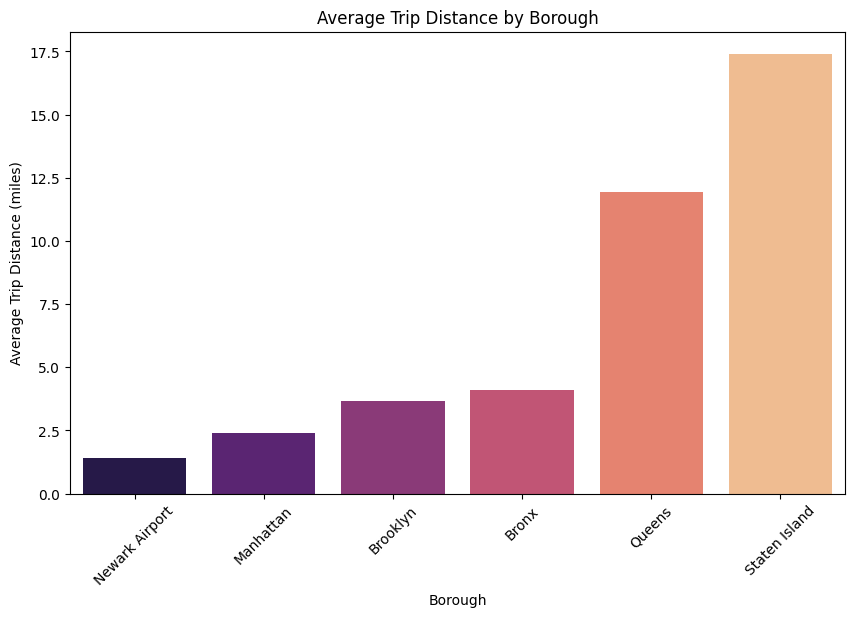

In [ ]:
# Sort data by average trip distance for plotting
distance_fare_stats_borough_sorted_distance = distance_fare_stats_borough.sort_values(by='trip_distance')

# Plot average trip distance by borough
plt.figure(figsize=(10, 6))
sns.barplot(
    data=distance_fare_stats_borough_sorted_distance,
    x='pickup_borough',
    y='trip_distance',
    ci=None,
    palette="magma"
)
plt.title("Average Trip Distance by Borough")
plt.xlabel("Borough")
plt.ylabel("Average Trip Distance (miles)")
plt.xticks(rotation=45)
plt.show()

The graph shows that Staten Island and Queens have the longest average trip distances, reflecting their geographical spread and connectivity needs, while Newark Airport and Manhattan have the shortest, indicating their compact areas and frequent shorter trips.

**Trip trends by Passenger Count**

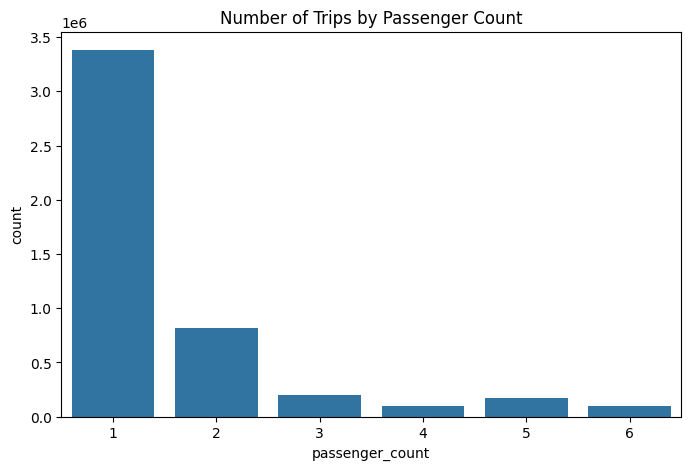

In [ ]:
# Analyze trip distribution by passenger count
plt.figure(figsize=(8, 5))
sns.countplot(data, x='passenger_count')
plt.title("Number of Trips by Passenger Count")
plt.show()

The graph shows that the majority of taxi trips are for a single passenger, indicating a high demand for individual travel. Two-passenger trips follow as the next most frequent, while trips with three or more passengers are significantly less common. This highlights that taxi services are primarily used for individual or small group commutes.

**Merge the trip data with its shape file to get back the location geometries**

In [ ]:
import os
os.environ["SHAPE_RESTORE_SHX"] = "YES"
taxi_zone_gdf = gpd.read_file("taxi_zones.shp")
taxi_zone_gdf.set_crs("EPSG:2263", inplace=True)
# Reproject to WGS84 (latitude and longitude)
taxi_zone_gdf = taxi_zone_gdf.to_crs("EPSG:4326")
# Reset the index and add 1 to match LocationID values
taxi_zone_gdf = taxi_zone_gdf.reset_index()
taxi_zone_gdf['ID'] = range(1, len(taxi_zone_gdf) + 1)  # Adjust index to match LocationID
taxi_zone_gdf.drop(columns=['index'], inplace=True)


**Load the bus routes data**

In [ ]:
from shapely import wkt

bus_routes = gpd.read_file('bus_routes_2019_nyc_ud.csv')

# Convert 'geometry' column from WKT format to Shapely geometry
bus_routes['geometry'] = bus_routes['geometry'].apply(wkt.loads)

# Convert to GeoDataFrame
bus_routes = gpd.GeoDataFrame(bus_routes, geometry='geometry')

**Analyze the bus routes where there are no taxi service available**

In [ ]:
!pip install folium

In [ ]:
import folium

# Highlight taxi zones dynamically based on no bus routes
zones_without_bus_routes = []  # Initialize empty list for zones without bus routes

# Identify zones without bus routes
for _, zone_row in taxi_zone_data_with_geom.iterrows():
    intersects = bus_routes['geometry'].intersects(zone_row['geometry']).any()
    if not intersects:
        zones_without_bus_routes.append(zone_row['ID'])

# Create a base map
m = folium.Map(location=[40.7128, -74.0060], zoom_start=12, tiles="cartodb positron")

# Add taxi zones to the map with conditional styling
for _, row in taxi_zone_data_with_geom.iterrows():
    color = 'green' if row['LocationID'] in zones_without_bus_routes else 'blue'  # Green for zones without bus routes
    fill_opacity = 0.4 if row['LocationID'] in zones_without_bus_routes else 0.1
    folium.GeoJson(
        row['geometry'],
        style_function=lambda x, color=color, fill_opacity=fill_opacity: {
            'fillColor': color,
            'color': 'black',
            'weight': 1,
            'fillOpacity': fill_opacity
        },
        tooltip=f"Location ID: {row['LocationID']}"
    ).add_to(m)

# Add bus routes to the map
for _, row in bus_routes.iterrows():
    folium.GeoJson(
        row['geometry'],
        style_function=lambda x: {
            'color': 'red',
            'weight': 2,
            'opacity': 0.4
        },
        tooltip="Bus Route"
    ).add_to(m)

# Add a title to the map
title_html = '''
             <h3 align="center" style="font-size:20px"><b>Taxi Zones Without Bus Routes Highlighted in Green</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))

# Save or display the map
m.save("nyc_zones_without_bus_routes.html")
m

Output hidden; open in https://colab.research.google.com to view.

The above figure shows NYC's taxi and bus transportation systems, the bus routes are in red and zones with taxi availability is outlined with black. There are taxi zones existing without bus routes, which are higlighted in green.

**Analyze the trends of taxi trip volume**

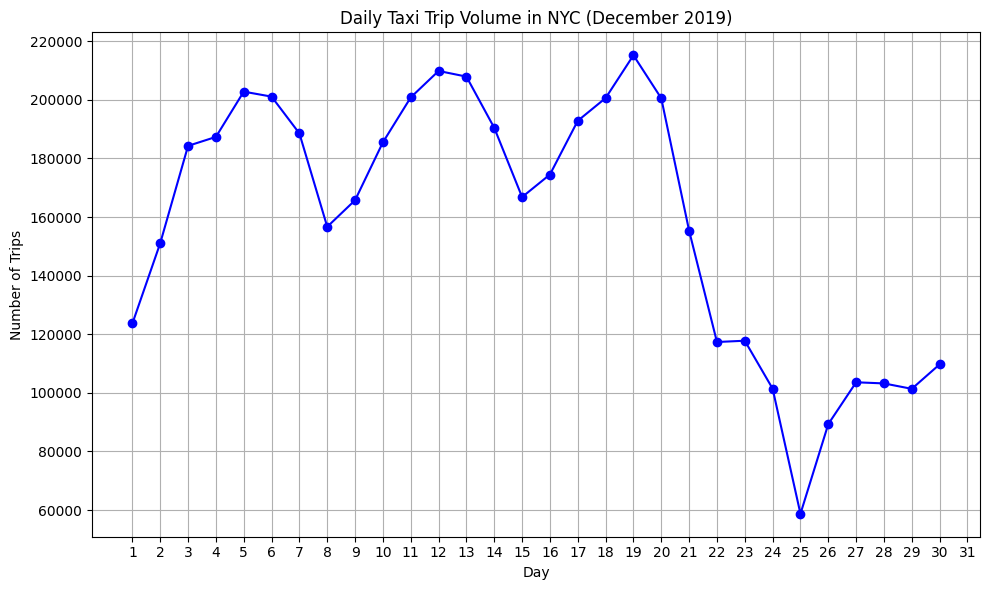

In [ ]:
# Ensure pickup_date is in datetime format
data['pickup_date'] = pd.to_datetime(data['pickup_date'])

# Group by day and count the number of trips
daily_trip_counts = data.groupby(data['pickup_date'].dt.day)['pickup_date'].count()

# Plot daily trip volume
plt.figure(figsize=(10, 6))
plt.plot(daily_trip_counts.index, daily_trip_counts.values, marker='o', color='blue')
plt.title("Daily Taxi Trip Volume in NYC (December 2019)")
plt.xlabel("Day")
plt.ylabel("Number of Trips")
plt.grid(True)
plt.xticks(range(1, 32))  # Ensure x-axis shows all days
plt.tight_layout()
plt.show()

The graph illustrates daily taxi trip variations in December 2019, showing an increase in trips early in the month, peaking mid-month, and declining near the holiday season. These variations highlight the impact of holidays on commuting patterns, offering insights for planning bus routes or increasing frequency during peak periods.

**Top pickup and dropoff zones**

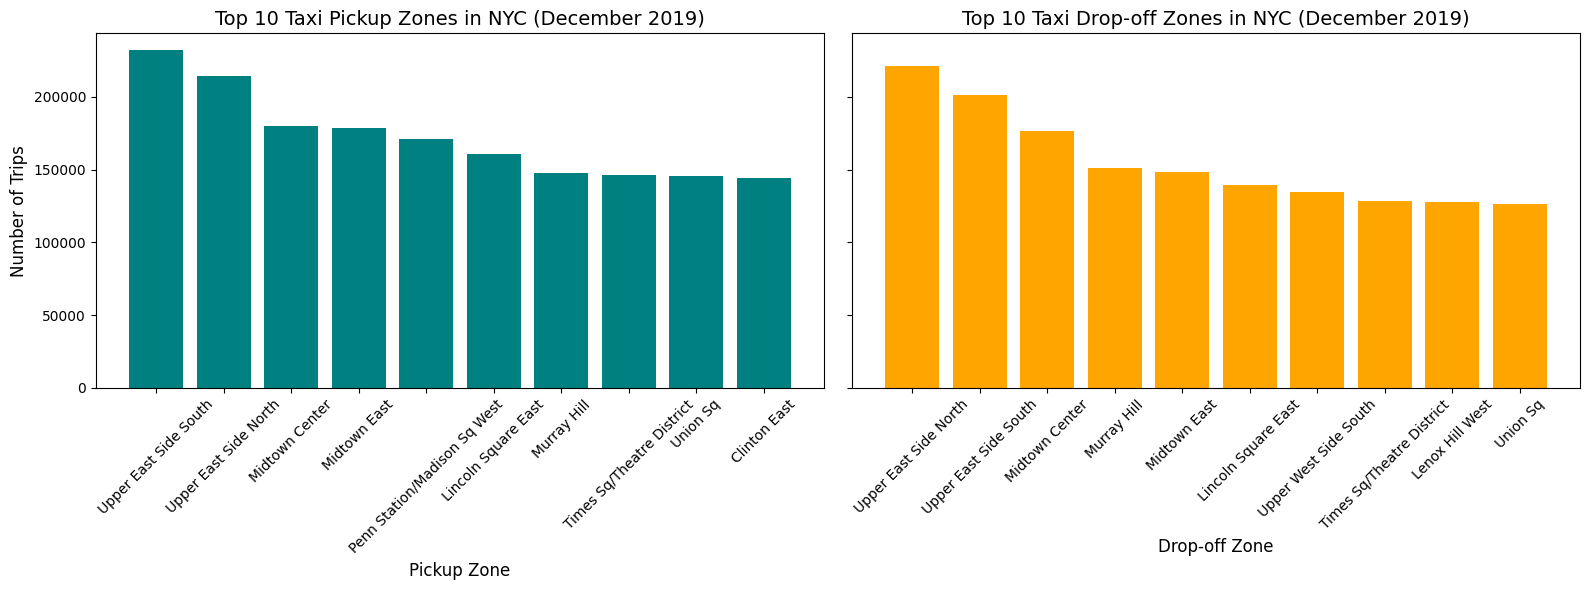

In [ ]:
# Group data by pickup and drop-off zones and count the number of trips
pickup_counts = data['pickup_zone'].value_counts().head(10)
dropoff_counts = data['dropoff_zone'].value_counts().head(10)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot pickup zones
axes[0].bar(pickup_counts.index, pickup_counts.values, color='teal')
axes[0].set_title('Top 10 Taxi Pickup Zones in NYC (December 2019)', fontsize=14)
axes[0].set_xlabel('Pickup Zone', fontsize=12)
axes[0].set_ylabel('Number of Trips', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Plot drop-off zones
axes[1].bar(dropoff_counts.index, dropoff_counts.values, color='orange')
axes[1].set_title('Top 10 Taxi Drop-off Zones in NYC (December 2019)', fontsize=14)
axes[1].set_xlabel('Drop-off Zone', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

The plot highlights the top taxi pickup and drop-off zones, with areas like "Upper East Side North" and "Midtown Center" showing the highest demand. These zones indicate the need for enhanced public transportation to reduce taxi-induced traffic and provide alternative commuting options, guiding the prioritization of bus route expansion and frequency increases.

**Weekday Commute Demand Analysis**

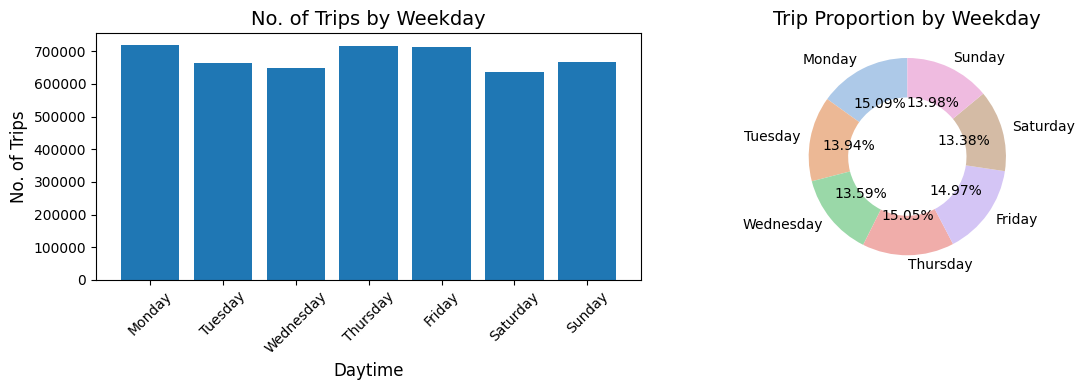

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
data['pickup_date'] = pd.to_datetime(data['pickup_date'])
data['weekday'] = data['pickup_date'].dt.day_name()
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_counts = data['weekday'].value_counts().reindex(weekday_order)
weekday_prop = (weekday_counts / weekday_counts.sum()) * 100

# Define a light pastel color palette
light_pastel_colors = sns.color_palette("pastel", len(weekday_counts)).as_hex()
light_pastel_colors = [sns.desaturate(color, 0.7) for color in light_pastel_colors]  # Desaturate for lighter shades

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart for trips by weekday
axes[0].bar(weekday_counts.index, weekday_counts.values)
axes[0].set_title('No. of Trips by Weekday', fontsize=14)
axes[0].set_xlabel('Daytime', fontsize=12)
axes[0].set_ylabel('No. of Trips', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Pie chart for trip proportion by weekday
axes[1].pie(weekday_prop.values, labels=weekday_prop.index, autopct='%1.2f%%', startangle=90,
            colors=light_pastel_colors, wedgeprops={'width': 0.4})
axes[1].set_title('Trip Proportion by Weekday', fontsize=14)

plt.tight_layout()
plt.show()


The figure shows that the distribution of trips across weekdays and weekends, with the highest average trip counts observed on Mondays and Tuesdays, indicating higher commute demand at the start of the week. Tuesday records the peak average trip count, emphasizing the need for enhanced public transportation during weekdays to meet demand efficiently.

**Population vs. Taxi Demand per Borough**

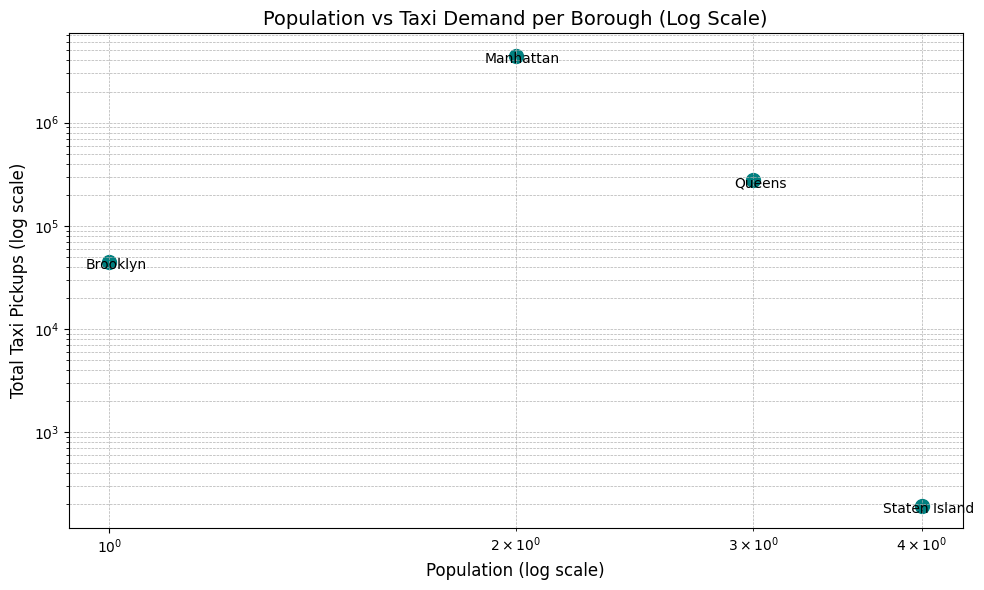

In [ ]:
# Calculate total pickups by borough
taxi_demand_by_borough = data['pickup_borough'].value_counts().reset_index()
taxi_demand_by_borough.columns = ['pickup_borough', 'Total Pickups']

# Load the NYC population dataset
population_df = pd.read_csv('NYC_Population.csv')

# Check column names and aggregate population data by borough
population_by_borough = population_df.groupby('Borough')['Population'].sum().reset_index()

# Ensure consistency in column names for merging
population_by_borough.rename(columns={'Borough': 'pickup_borough'}, inplace=True)

# Merge population data with taxi demand data
borough_data = pd.merge(population_by_borough, taxi_demand_by_borough, on='pickup_borough', how='inner')

# Scatter plot for population vs. taxi demand with log scale
plt.figure(figsize=(10, 6))
plt.scatter(borough_data['Population'], borough_data['Total Pickups'], color='teal', s=100)
plt.xscale('log')
plt.yscale('log')
plt.title("Population vs Taxi Demand per Borough (Log Scale)", fontsize=14)
plt.xlabel("Population (log scale)", fontsize=12)
plt.ylabel("Total Taxi Pickups (log scale)", fontsize=12)
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Annotate each point with borough names
for i, row in borough_data.iterrows():
    plt.annotate(row['pickup_borough'], (row['Population'], row['Total Pickups']),
                 textcoords="offset points", xytext=(5, -5), ha='center', fontsize=10)

plt.tight_layout()
plt.show()


The graph highlights the relationship between population size and taxi demand in NYC boroughs, showing Manhattan's high taxi demand despite lower population, likely due to its commercial and tourist activity, emphasizing the need for improved transit options to address congestion.

**Analyze the Population of Taxi Zones Without Bus Coverage**

In [ ]:
# Identify the taxi locationIDs where there are no bus services

# Ensure both dataframes have geometry columns
taxi_zone_gdf.set_geometry('geometry', inplace=True)
bus_routes.set_geometry('geometry', inplace=True)

# Find taxi zones without any intersecting bus routes
zones_without_bus_routes = []
for _, zone_row in taxi_zone_gdf.iterrows():
    intersects = bus_routes['geometry'].intersects(zone_row['geometry']).any()
    if not intersects:
        zones_without_bus_routes.append(zone_row['ID'])

print("Taxi Zone IDs without bus routes:")
print(zones_without_bus_routes)


Taxi Zone IDs without bus routes:
[1, 27, 40, 46, 52, 54, 57, 103, 104, 105, 110, 194, 195, 199, 207]


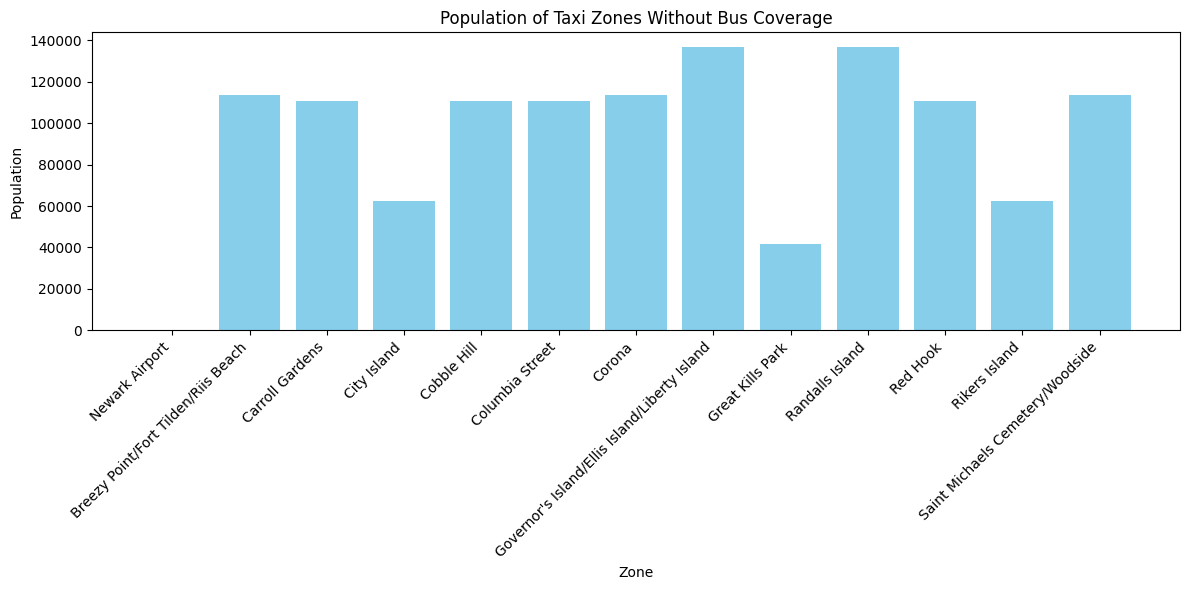

In [ ]:
# Load taxi zone lookup data to get zone names for the IDs without bus coverage
taxi_zones_df = pd.read_csv("taxi_zone_lookup.csv")
# Filter taxi zones without bus coverage
zones_without_bus_df = taxi_zones_df[taxi_zones_df['LocationID'].isin(zones_without_bus_routes)]

# Attempt to merge population data by borough
zones_population_df = zones_without_bus_df.merge(population_df, left_on='Borough', right_on='Borough', how='left')

# Fill missing population values with 0
zones_population_df['Population'] = zones_population_df['Population'].str.replace(",", "").fillna(0).astype(int)

# Plotting population for each zone without bus coverage
plt.figure(figsize=(12, 6))
plt.bar(zones_population_df['Zone'], zones_population_df['Population'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Population of Taxi Zones Without Bus Coverage")
plt.xlabel("Zone")
plt.ylabel("Population")
plt.tight_layout()
plt.show()



The graph identifies zones without bus routes, such as "Great Kills Park" and "Rikers Island," highlighting areas with significant populations lacking public transport. It reveals gaps in transit services and serves as a foundation for expanding bus routes to reduce citizens' fare burden and taxi congestion.

# **Exploratory Data Analysis II**

**Density of high trip zones with no bus coverage**

In [ ]:
taxi_zones_df = taxi_zone_data_with_geom.copy()

In [ ]:
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

# Convert geometry strings to Shapely geometries only if they are strings
taxi_zones_df['geometry'] = taxi_zones_df['geometry'].apply(lambda x: wkt.loads(x) if isinstance(x, str) else x)
bus_routes['geometry'] = bus_routes['geometry'].apply(lambda x: wkt.loads(x) if isinstance(x, str) else x)

# Convert taxi_geom and bus_routes to GeoDataFrames with correct geometry column
taxi_zones_gdf = gpd.GeoDataFrame(taxi_zones_df, geometry='geometry', crs="EPSG:4326")
bus_routes_gdf = gpd.GeoDataFrame(bus_routes, geometry='geometry', crs="EPSG:4326")

# Ensure both GeoDataFrames are in the same CRS; reproject if necessary
if taxi_zones_gdf.crs != bus_routes_gdf.crs:
    bus_routes_gdf = bus_routes_gdf.to_crs(taxi_zones_gdf.crs)

# Spatial join to find taxi zones with bus coverage
taxi_zones_with_bus = gpd.sjoin(taxi_zones_gdf, bus_routes_gdf, predicate='intersects', how='inner')

# Find zones without bus coverage
zones_without_bus = taxi_zones_gdf[~taxi_zones_gdf['ID'].isin(taxi_zones_with_bus['ID'])]

# Display the result
print("The zones without bus services:\n", zones_without_bus[['LocationID', 'Zone']])

The zones without bus services:
      LocationID                                           Zone
0             1                                 Newark Airport
26           27            Breezy Point/Fort Tilden/Riis Beach
39           40                                Carroll Gardens
45           46                                    City Island
51           52                                    Cobble Hill
53           54                                Columbia Street
56           57                                         Corona
102         103  Governor's Island/Ellis Island/Liberty Island
103         104  Governor's Island/Ellis Island/Liberty Island
104         105  Governor's Island/Ellis Island/Liberty Island
109         110                               Great Kills Park
193         194                                Randalls Island
194         195                                       Red Hook
198         199                                  Rikers Island
206         207       

In [ ]:
# Identify high-trip zones from trip_df
high_trip_zones = data['pickup_zone'].value_counts().head(10).index
print("The hight trip zones are as follows: ", high_trip_zones)

The hight trip zones are as follows:  Index(['Upper East Side South', 'Upper East Side North', 'Midtown Center',
       'Midtown East', 'Penn Station/Madison Sq West', 'Lincoln Square East',
       'Murray Hill', 'Times Sq/Theatre District', 'Union Sq', 'Clinton East'],
      dtype='object', name='pickup_zone')


It is observed that zones with bus routes still exhibit a high volume of taxi trips, indicating a preference for taxis despite the availability of buses. This suggests these areas may have higher-income populations..

In [ ]:
# Ignore all warnings
warnings.filterwarnings('ignore')

zones_without_bus_ids = list(zones_without_bus['LocationID'])

# Filter trips with pickup or drop-off in zones without bus coverage
trips_in_zones_without_bus = data[
    (data['PULocationID'].isin(zones_without_bus_ids)) |
    (data['DOLocationID'].isin(zones_without_bus_ids))
]

# Count trips based on pickup and drop-off locations
pickup_counts = trips_in_zones_without_bus[data['PULocationID'].isin(zones_without_bus_ids)].shape[0]
dropoff_counts = trips_in_zones_without_bus[data['DOLocationID'].isin(zones_without_bus_ids)].shape[0]

# Total trips in zones without bus coverage
total_trips = trips_in_zones_without_bus.shape[0]

# Display the results
print(f"Total trips in zones without bus coverage (pickup or drop-off): {total_trips}")
print(f"Trips with pickup in zones without bus coverage: {pickup_counts}")
print(f"Trips with drop-off in zones without bus coverage: {dropoff_counts}")

Total trips in zones without bus coverage (pickup or drop-off): 32354
Trips with pickup in zones without bus coverage: 6307
Trips with drop-off in zones without bus coverage: 27322


**Comparison of Mean Trips Across All Zones vs Mean Trips in Zones Without Bus**

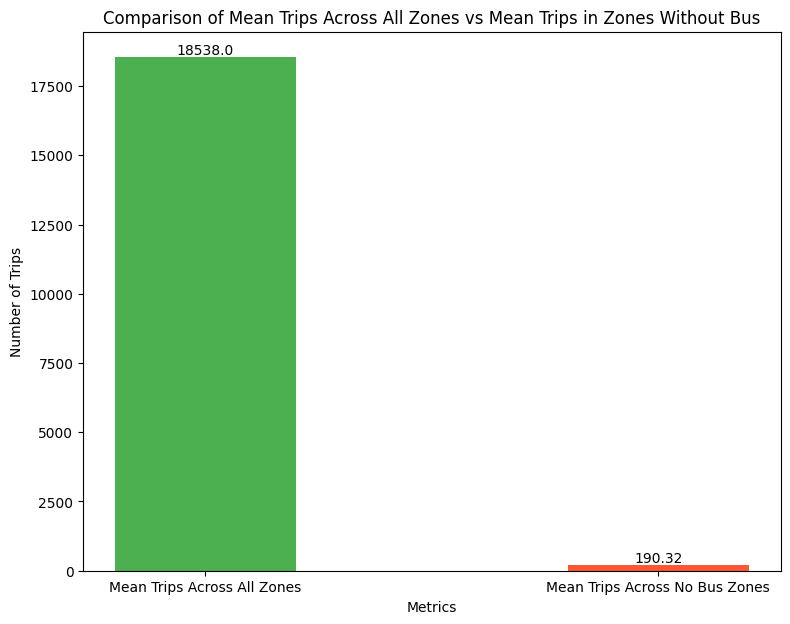

In [ ]:
# Compute mean trips across all zones
mean_trips_all_zones = data['PULocationID'].value_counts().mean()

# Compute total trips in zones without bus coverage
mean_trips_no_bus_zones = trips_in_zones_without_bus['PULocationID'].value_counts().mean()

# Create a DataFrame for the plot
comparison_data = pd.DataFrame({
    'Metric': ['Mean Trips Across All Zones', 'Mean Trips Across No Bus Zones'],
    'Trips': [mean_trips_all_zones, mean_trips_no_bus_zones]
})

# Plotting
plt.figure(figsize=(9, 7))
bars = plt.bar(comparison_data['Metric'], comparison_data['Trips'], color=['#4CAF50', '#FF5733'],width = 0.4)

# Add labels to each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

# Customize the plot
plt.title('Comparison of Mean Trips Across All Zones vs Mean Trips in Zones Without Bus')
plt.xlabel('Metrics')
plt.ylabel('Number of Trips')
plt.show()


Zones with bus routes have significantly higher mean trips compared to zones without bus routes, indicating limited transportation options in bus-deficient areas and the need to expand public transit services.

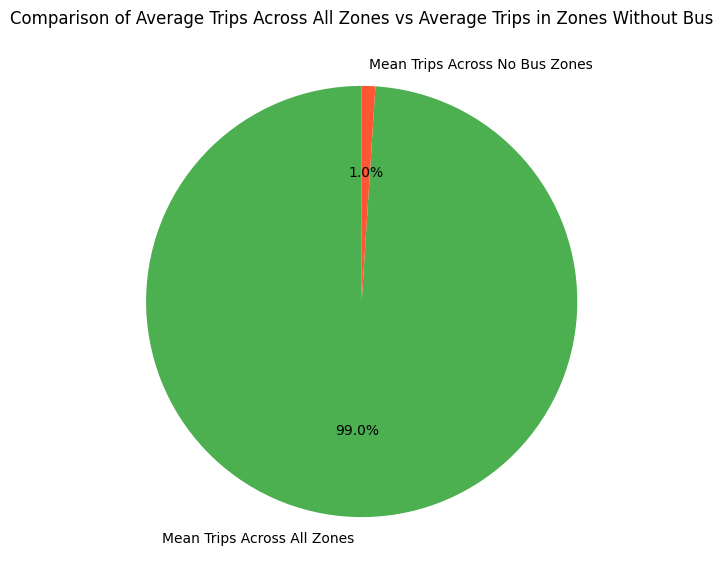

In [ ]:
# Plotting as a pie chart
plt.figure(figsize=(7, 7))
plt.pie(
    comparison_data['Trips'],
    labels=comparison_data['Metric'],
    autopct='%1.1f%%',
    startangle=90,
    colors=['#4CAF50', '#FF5733']
)
plt.title('Comparison of Average Trips Across All Zones vs Average Trips in Zones Without Bus')
plt.show()


It can be seen from the pie chart above that only 0.8% of trips occur in no-bus zones while 99.2% of the trips are performed in zones which have bus routes. This observation is in sharp contrast and invokes the conclusion that a higher number of trips is likely to be made in places where bus routes are available. The low friction for trips in no-bus zones indicates low commuter activities in the areas.

**Fare Burden Analysis**

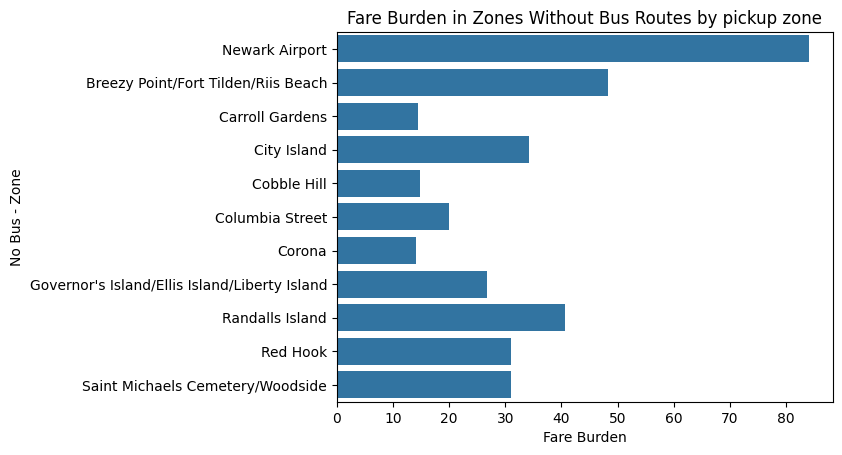

In [ ]:
# Calculate fare burden per zone without bus routes
# pickup
fare_burden = data.groupby('PULocationID')['fare_amount'].mean().reset_index()
fare_burden = fare_burden[fare_burden['PULocationID'].isin(zones_without_bus['LocationID'])]

# Merge with taxi zone data
fare_burden = fare_burden.merge(taxi_zone_lkup_csv, left_on='PULocationID', right_on='LocationID')

# Plot fare burden for zones without bus routes
sns.barplot(data=fare_burden, y='Zone', x='fare_amount')
# plt.xticks(rotation=90)
plt.title("Fare Burden in Zones Without Bus Routes by pickup zone")
plt.ylabel("No Bus - Zone")
plt.xlabel("Fare Burden")
plt.show()


The chart highlights significant monthly savings potential for zones without bus coverage, such as Newark Airport ($60,000) and areas like Cobble Hill and Red Hook. Even zones with lower savings, like Columbia Street and Randall's Island, show the financial burden of limited public transit, emphasizing the need for affordable bus services to promote equitable transportation.

**Potential Savings with Bus Service by Zone**

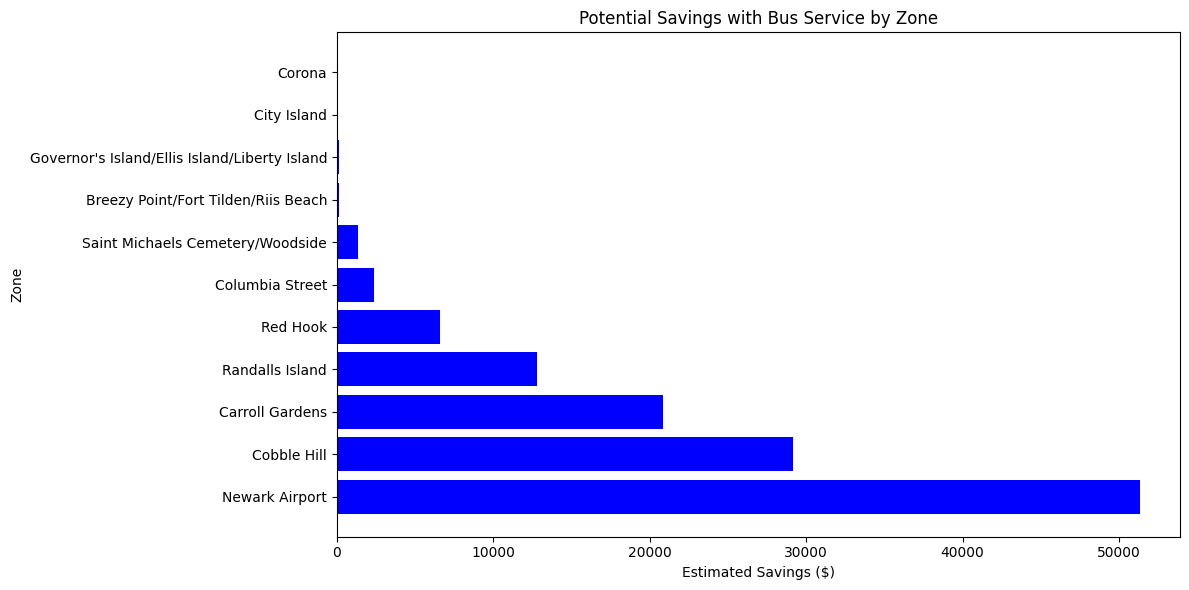

In [ ]:
# Assuming trip_data contains taxi trip data and zones_without_bus contains zones without bus routes

def calculate_and_plot_savings(trip_data, zones_without_bus, taxi_zone_borough_name_gdf):
    """
    Calculate potential savings and plot for zones without bus service.
    """
    # Filter trips to zones without bus service
    trips_no_bus = trip_data[trip_data['PULocationID'].isin(zones_without_bus['LocationID'])]

    # Calculate total fare and passenger counts by zone
    spending_data = trips_no_bus.groupby('PULocationID').agg({
        'fare_amount': 'sum',
        'passenger_count': 'sum'
    }).reset_index()

    # Merge with zone names
    spending_data = spending_data.merge(
        taxi_zone_borough_name_gdf[['LocationID', 'Zone']],
        left_on='PULocationID',
        right_on='LocationID'
    )

    # Estimate potential savings assuming $2.75 bus fare per passenger
    BUS_FARE = 2.75
    spending_data['potential_savings'] = spending_data['fare_amount'] - (spending_data['passenger_count'] * BUS_FARE)
    spending_data['potential_savings'] = spending_data['potential_savings'].clip(lower=0)  # Ensure no negative values

    # Sort by potential savings
    spending_data_sorted = spending_data.sort_values(by='potential_savings', ascending=False)

    # Plot the savings
    plt.figure(figsize=(12, 6))
    plt.barh(spending_data_sorted['Zone'], spending_data_sorted['potential_savings'], color='blue')
    plt.title('Potential Savings with Bus Service by Zone')
    plt.xlabel('Estimated Savings ($)')
    plt.ylabel('Zone')
    plt.tight_layout()
    plt.show()

# Call the function
calculate_and_plot_savings(data, zones_without_bus, taxi_zone_data_with_geom)


The bar chart highlights the potential cost savings from implementing bus services in underserved zones. Newark Airport has the highest estimated savings, exceeding $50,000, indicating a significant need for affordable public transportation. Other zones, such as Cobble Hill, Carroll Gardens, and Red Hook, also show notable savings potential, emphasizing the financial burden residents face due to limited transit options. Introducing bus services in these areas could provide economic relief and equitable commuting solutions.

**Environmental Impact Analysis**

In [ ]:
# Define taxi emission rate (grams of CO₂ per mile)
taxi_emission_rate = 404

# Filter trips from zones without bus routes
trip_df_no_bus = data[data['DOLocationID'].isin(zones_without_bus['LocationID'])]

# Calculate emissions for each trip and total emissions
trip_df_no_bus['estimated_emissions'] = trip_df_no_bus['trip_distance'] * taxi_emission_rate
total_emissions_no_bus_grams = trip_df_no_bus['estimated_emissions'].sum()
total_emissions_no_bus_tons1 = total_emissions_no_bus_grams / 1_000_000  # Convert to metric tons

# Print results estimated CO₂ emissions in grams for trips originating from dropoff zones without bus routes
print("Emissions estimated CO₂ emissions in grams for trips originating from dropoff zones without bus routes ")
print(f"Total CO₂ emissions in grams: {total_emissions_no_bus_grams} grams")
print(f"Total CO₂ emissions in tons: {total_emissions_no_bus_tons1:.2f} metric tons")


Emissions estimated CO₂ emissions in grams for trips originating from dropoff zones without bus routes 
Total CO₂ emissions in grams: 132142857.12000002 grams
Total CO₂ emissions in tons: 132.14 metric tons


In [ ]:
# Define taxi emission rate (grams of CO₂ per mile)
taxi_emission_rate = 404

# Filter trips from zones without bus routes
trip_df_no_bus = data[data['PULocationID'].isin(zones_without_bus['LocationID'])]

# Calculate emissions for each trip and total emissions
trip_df_no_bus['estimated_emissions'] = trip_df_no_bus['trip_distance'] * taxi_emission_rate
total_emissions_no_bus_grams = trip_df_no_bus['estimated_emissions'].sum()
total_emissions_no_bus_tons2 = total_emissions_no_bus_grams / 1_000_000  # Convert to metric tons

# Print results estimated CO₂ emissions in grams for trips originating from pickup zones without bus routes
print("Emissions estimated CO₂ emissions in grams for trips originating from pickup zones without bus routes ")
print(f"Total CO₂ emissions in grams: {total_emissions_no_bus_grams} grams")
print(f"Total CO₂ emissions in tons: {total_emissions_no_bus_tons2:.2f} metric tons")


Emissions estimated CO₂ emissions in grams for trips originating from pickup zones without bus routes 
Total CO₂ emissions in grams: 9424815.0 grams
Total CO₂ emissions in tons: 9.42 metric tons


In [ ]:
print(f"Total estimated CO₂ emissions in metric tons in zones without bus network:\n {total_emissions_no_bus_tons1 +total_emissions_no_bus_tons2:.2f} metric tons")

Total estimated CO₂ emissions in metric tons in zones without bus network:
 141.57 metric tons


The environmental impact analysis reveals that taxi trips originating from zones without a bus network contribute approximately 141.57 metric tons of CO₂ emissions. This highlights the substantial environmental burden caused by a lack of public transportation options. Implementing bus services in these zones could significantly reduce emissions, promoting sustainable and eco-friendly urban mobility.

**Hourly Demand for Zones Without Bus Routes by Month**

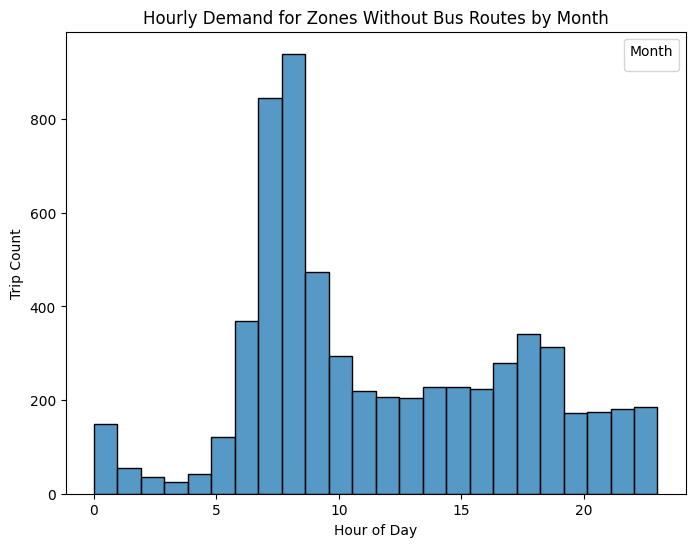

In [ ]:
warnings.filterwarnings('ignore')

# Filter data for zones without bus routes
trip_df_no_bus = data[data['PULocationID'].isin(zones_without_bus['LocationID'])]

# Plot time-based demand per month for zones without bus routes
plt.figure(figsize=(8, 6))
sns.histplot(data=trip_df_no_bus, x='pickup_hour', bins=24, multiple='stack')
plt.title("Hourly Demand for Zones Without Bus Routes by Month")
plt.xlabel("Hour of Day")
plt.ylabel("Trip Count")
plt.legend(title="Month", loc='upper right')
plt.show()




The plot shows peak taxi demand in no-bus zones during 6 AM to 9 AM, likely driven by work commutes. Targeted bus routes, such as connecting Times Square to Newark Airport during these hours, can reduce taxi reliance and address demand efficiently.

**Hourly Taxi Demand in Zones Without Bus Service**

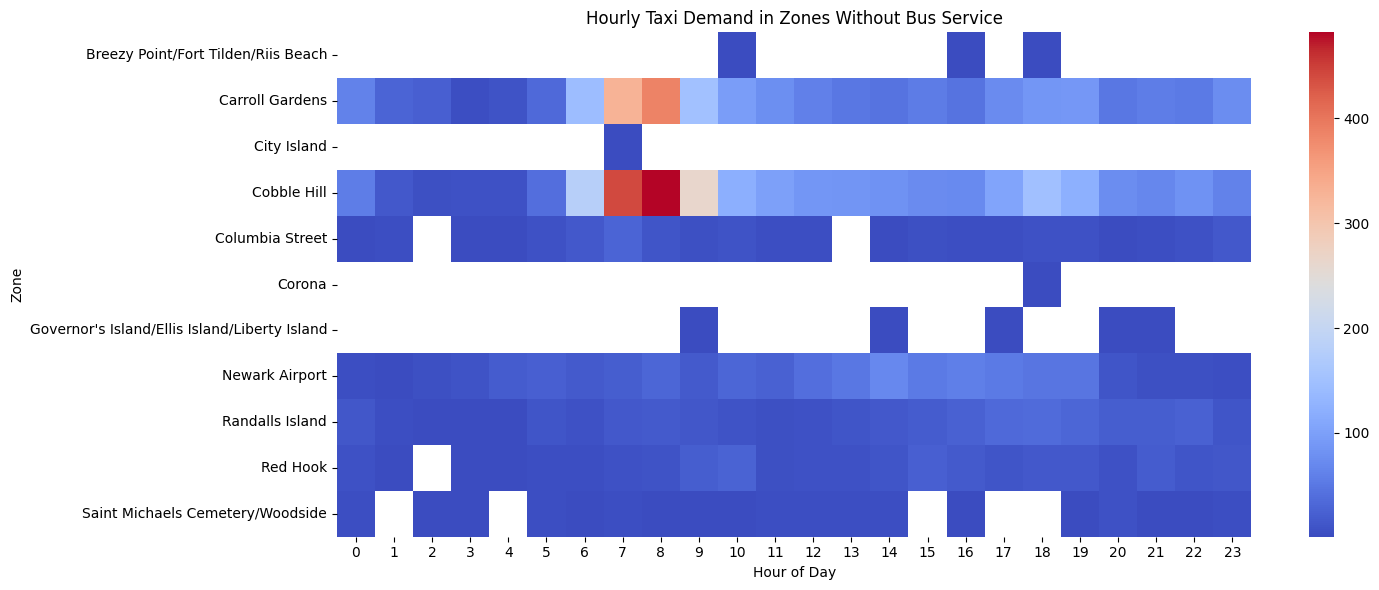

In [ ]:
def analyze_cost_burden(data, zones_without_bus):
    """
    Analyze fare patterns and potential savings in zones without bus service.
    """
    # Filter trips in zones without bus service
    trips_no_bus = data[data['PULocationID'].isin(zones_without_bus['LocationID'])].copy()

    # Calculate daily metrics
    daily_metrics = trips_no_bus.groupby('PULocationID').agg(
        total_amount=('total_amount', 'sum'),
        avg_trip_cost=('total_amount', 'mean'),
        daily_trips=('total_amount', 'count'),
        avg_trip_distance=('trip_distance', 'mean')
    ).reset_index()

    # Adjust for daily averages
    num_days = data['pickup_date'].dt.date.nunique()
    daily_metrics[['total_amount', 'daily_trips']] /= num_days

    # Calculate potential savings
    BUS_FARE, CONVERSION_RATE, TIME_COST, EXTRA_TIME = 2.75, 0.7, 15 / 60, 15
    daily_metrics['potential_savings'] = (
        daily_metrics['daily_trips'] * CONVERSION_RATE * (
            daily_metrics['avg_trip_cost'] - (BUS_FARE + TIME_COST * EXTRA_TIME)
        )
    ).clip(lower=0).round(2)

    return daily_metrics

def analyze_zone_demand(data, zones_without_bus):
    """
    Analyze taxi demand patterns in zones without bus service.
    """
    # Filter and extract time-based data
    trips_no_bus = data[data['PULocationID'].isin(zones_without_bus['LocationID'])].copy()
    trips_no_bus['hour'] = trips_no_bus['pickup_hour']

    # Hourly demand and peak hours
    hourly_demand = trips_no_bus.groupby(['PULocationID', 'hour']).size().reset_index(name='trip_count')
    peak_hours = hourly_demand.groupby('PULocationID').apply(
        lambda x: x.nlargest(6, 'trip_count')['hour'].tolist()
    ).reset_index()

    return hourly_demand, peak_hours

def plot_demand_patterns(hourly_demand, taxi_geom):
    """
    Create a heatmap of hourly taxi demand by zone.
    """
    hourly_demand = hourly_demand.merge(taxi_geom[['LocationID', 'Zone']], left_on='PULocationID', right_on='LocationID')
    pivot_demand = hourly_demand.pivot(index='Zone', columns='hour', values='trip_count')

    plt.figure(figsize=(15, 6))
    sns.heatmap(pivot_demand, cmap='coolwarm', fmt='g', annot=False)
    plt.title('Hourly Taxi Demand in Zones Without Bus Service')
    plt.xlabel('Hour of Day')
    plt.ylabel('Zone')
    plt.tight_layout()
    plt.show()


# Run the analysis and create visualizations
hourly_demand, peak_hours = analyze_zone_demand(data, zones_without_bus)
daily_metrics = analyze_cost_burden(data, zones_without_bus)

plot_demand_patterns(hourly_demand, taxi_zone_data_with_geom)


The heatmap reveals hourly taxi demand in zones without bus services, offering insights for strategic bus deployment to optimize public transport. By addressing peak demand times and locations, such as deploying buses from Times Square to Newark Airport on Sundays at 2:00 PM, this approach can reduce carbon emissions, enhance public savings, and promote sustainable transportation solutions while benefiting both commuters and authorities.

**To offer more refined bus route recommendation**

In [ ]:
# Identify the most frequent Drop-off Zone (DOLocationID)
most_dropoff_zone = trip_df_no_bus['DOLocationID'].value_counts().idxmax()

# Find the most common Pickup Location (PULocationID) for this Drop-off Zone
top_pickup_for_dropoff = (
    trip_df_no_bus[trip_df_no_bus['DOLocationID'] == most_dropoff_zone]['PULocationID']
    .value_counts()
    .idxmax()
)

# Filter data for this specific Pickup-Drop-off route
route_df = trip_df_no_bus[
    (trip_df_no_bus['PULocationID'] == top_pickup_for_dropoff) &
    (trip_df_no_bus['DOLocationID'] == most_dropoff_zone)
]

# Determine peak time and day of the week
# Find the most frequent hour and day for trips between the identified Pickup and Drop-off zones
peak_hour = route_df['pickup_hour'].value_counts().idxmax()
peak_day = route_df['weekday'].value_counts().idxmax()

print(f"Most frequent Drop-off Zone without bus service: {most_dropoff_zone}")
print(f"Most common Pickup Location to this Drop-off Zone: {top_pickup_for_dropoff}")
print(f"Peak hour for trips from {top_pickup_for_dropoff} to {most_dropoff_zone}: {peak_hour}:00")
print(f"Peak day of the week for trips: {peak_day}")


Most frequent Drop-off Zone without bus service: 33
Most common Pickup Location to this Drop-off Zone: 52
Peak hour for trips from 52 to 33: 7:00
Peak day of the week for trips: Monday


Most frequent Drop-off Zone without bus service:
 33 - Brooklyn Heights
Most common Pickup Location to this Drop-off Zone:
 52 - Cobble Hill
Peak hour for trips from Cobble Hill to Brooklyn Heights:
 7:00
Peak day of the week for trips:
 Monday


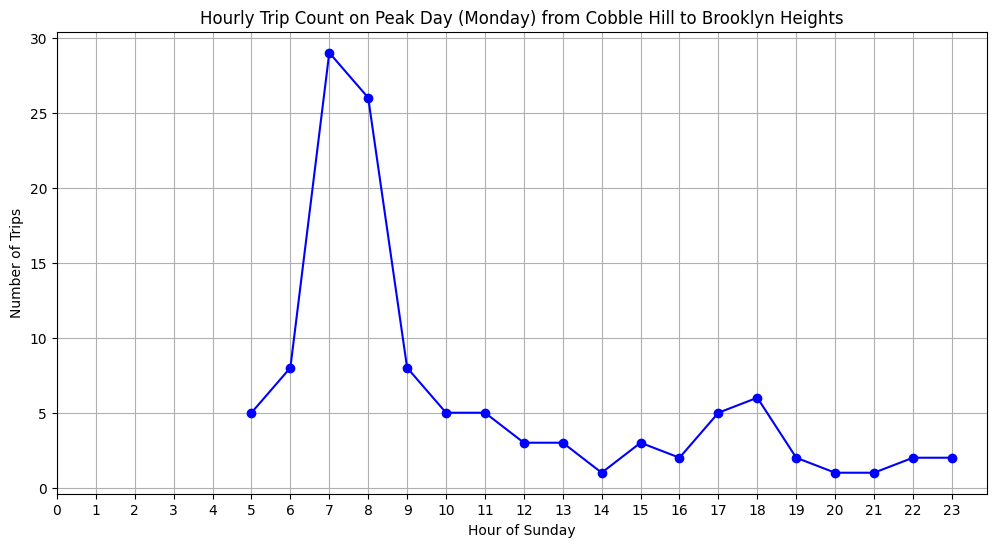

In [ ]:

# Identify the most frequent Drop-off Zone (DOLocationID)
most_dropoff_zone = trip_df_no_bus['DOLocationID'].value_counts().idxmax()

# Find the most common Pickup Location (PULocationID) for this Drop-off Zone
top_pickup_for_dropoff = (
    trip_df_no_bus[trip_df_no_bus['DOLocationID'] == most_dropoff_zone]['PULocationID']
    .value_counts()
    .idxmax()
)

# Get the zone names for the identified PULocationID and DOLocationID
pickup_zone_name = taxi_zone_lkup_csv.loc[taxi_zone_lkup_csv['LocationID'] == top_pickup_for_dropoff, 'Zone'].values[0]
dropoff_zone_name = taxi_zone_lkup_csv.loc[taxi_zone_lkup_csv['LocationID'] == most_dropoff_zone, 'Zone'].values[0]

# Filter data for this specific Pickup-Drop-off route
route_df = trip_df_no_bus[
    (trip_df_no_bus['PULocationID'] == top_pickup_for_dropoff) &
    (trip_df_no_bus['DOLocationID'] == most_dropoff_zone)
]


# Output the results with zone names
print(f"Most frequent Drop-off Zone without bus service:\n {most_dropoff_zone} - {dropoff_zone_name}")
print(f"Most common Pickup Location to this Drop-off Zone:\n {top_pickup_for_dropoff} - {pickup_zone_name}")
print(f"Peak hour for trips from {pickup_zone_name} to {dropoff_zone_name}:\n {peak_hour}:00")
print(f"Peak day of the week for trips:\n {peak_day}")

# Filter data for trips on the identified peak day
peak_day_data = route_df[route_df['weekday'] == peak_day]

# Count trips per hour on the peak day
hourly_trip_counts = peak_day_data['pickup_hour'].value_counts().sort_index()

# Plotting the hourly trend
plt.figure(figsize=(12, 6))
plt.plot(hourly_trip_counts.index, hourly_trip_counts.values, marker='o', linestyle='-', color='b')
plt.title(f'Hourly Trip Count on Peak Day ({peak_day}) from {pickup_zone_name} to {dropoff_zone_name}')
plt.xlabel('Hour of Sunday')
plt.ylabel('Number of Trips')
plt.xticks(range(0, 24))  # Set x-axis to show all 24 hours
plt.grid(True)
plt.show()



One such route recommendation could be to deploy a bus service from Cobble Hill to Brooklyn Heights on Mondays at 7:00 AM, addressing the peak hour and most common pickup-dropoff pattern for trips in this no-bus service zone. This approach could be extended to other zones and times, optimizing public transport coverage and meeting demand effectively.

# **Modeling**

#### Linear Regression
Performing fare analyses and cost comparision: A Linear Regression model is implemented to predict the fares and it also calculates the difference between bus fares and predicted fares. Based on this it gives whether any savings exist or not. This can be helpful for taking better decisions where taxi fares are high and where by increasing or adding bus facilities could save money for people. And this model can also be helpful for the citizens by providing them in an application so, that they can compare the prices and plan cost-effective travel.

Importing Necessary Libraries

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

Loading the dataset which was cleaned in the above steps.

In [ ]:
df = pd.read_parquet('cleaned_taxi_trip_data.parquet')

Displaying first 5 rows of the dataset

In [ ]:
df.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,...,dropoff_borough,dropoff_service_zone,trip_duration_minutes,day_type,pickup_hour,dropoff_hour,pickup_lat,pickup_long,dropoff_lat,dropoff_long
0,2,9.4,138,25,1,28.5,0.5,0.5,10.00,0.0,...,Brooklyn,Boro Zone,21.266667,weekend,0,0,40.774376,-73.873629,40.685634,-73.986114
1,2,0.5,79,224,1,4.0,3.0,0.5,1.55,0.0,...,Manhattan,Yellow Zone,2.900000,weekend,0,0,40.727620,-73.985937,40.731821,-73.976598
2,1,0.9,148,4,1,5.5,3.0,0.5,1.85,0.0,...,Manhattan,Yellow Zone,4.500000,weekend,0,0,40.718938,-73.990896,40.723752,-73.976968
3,3,5.5,79,226,1,18.0,3.0,0.5,4.35,0.0,...,Queens,Boro Zone,17.433333,weekend,0,0,40.727620,-73.985937,40.737699,-73.924673
4,2,17.4,132,141,1,52.0,2.5,0.5,5.53,0.0,...,Manhattan,Yellow Zone,26.783333,weekend,0,0,40.646985,-73.786533,40.766948,-73.959635


Displaying summary of the dataframe

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4764267 entries, 0 to 4764266
Data columns (total 29 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   passenger_count        int64  
 1   trip_distance          float64
 2   PULocationID           int64  
 3   DOLocationID           int64  
 4   payment_type           int64  
 5   fare_amount            float64
 6   extra                  float64
 7   mta_tax                float64
 8   tip_amount             float64
 9   tolls_amount           float64
 10  improvement_surcharge  float64
 11  total_amount           float64
 12  congestion_surcharge   float64
 13  pickup_date            object 
 14  dropoff_date           object 
 15  pickup_zone            object 
 16  pickup_borough         object 
 17  pickup_service_zone    object 
 18  dropoff_zone           object 
 19  dropoff_borough        object 
 20  dropoff_service_zone   object 
 21  trip_duration_minutes  float64
 22  day_type          

Displaying Shape of the Dataframe

In [ ]:
df.shape

(4764267, 29)

Checking the null values

In [ ]:
df.isnull().sum()

passenger_count          0
trip_distance            0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
pickup_date              0
dropoff_date             0
pickup_zone              0
pickup_borough           0
pickup_service_zone      0
dropoff_zone             0
dropoff_borough          0
dropoff_service_zone     0
trip_duration_minutes    0
day_type                 0
pickup_hour              0
dropoff_hour             0
pickup_lat               0
pickup_long              0
dropoff_lat              0
dropoff_long             0
dtype: int64

Considering bus fare as $3.0 per ride in New York city (ref: https://new.mta.info/fares#:~:text=Subways%20and%20buses,or%20pay%20with%20a%20MetroCard). The fare is considered from the Metropolitan Transportation Authority website.

In [ ]:
bus_fare = 3.0

Creating a new column 'bus_fare_cost' in the dataframe. This column contains the values of passenger_count*bus_fare. 'bus_fare_cost' column will be used in the last to compare the predicted cab fares and bus fares.

In [ ]:
df['bus_fare_cost'] = bus_fare * df['passenger_count']

In [ ]:
df.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,...,dropoff_service_zone,trip_duration_minutes,day_type,pickup_hour,dropoff_hour,pickup_lat,pickup_long,dropoff_lat,dropoff_long,bus_fare_cost
0,2,9.4,138,25,1,28.5,0.5,0.5,10.00,0.0,...,Boro Zone,21.266667,weekend,0,0,40.774376,-73.873629,40.685634,-73.986114,6.0
1,2,0.5,79,224,1,4.0,3.0,0.5,1.55,0.0,...,Yellow Zone,2.900000,weekend,0,0,40.727620,-73.985937,40.731821,-73.976598,6.0
2,1,0.9,148,4,1,5.5,3.0,0.5,1.85,0.0,...,Yellow Zone,4.500000,weekend,0,0,40.718938,-73.990896,40.723752,-73.976968,3.0
3,3,5.5,79,226,1,18.0,3.0,0.5,4.35,0.0,...,Boro Zone,17.433333,weekend,0,0,40.727620,-73.985937,40.737699,-73.924673,9.0
4,2,17.4,132,141,1,52.0,2.5,0.5,5.53,0.0,...,Yellow Zone,26.783333,weekend,0,0,40.646985,-73.786533,40.766948,-73.959635,6.0


Successfully added the bus_fare_cost column

In [ ]:
df.columns

Index(['passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'pickup_date', 'dropoff_date', 'pickup_zone',
       'pickup_borough', 'pickup_service_zone', 'dropoff_zone',
       'dropoff_borough', 'dropoff_service_zone', 'trip_duration_minutes',
       'day_type', 'pickup_hour', 'dropoff_hour', 'pickup_lat', 'pickup_long',
       'dropoff_lat', 'dropoff_long', 'bus_fare_cost'],
      dtype='object')

Dropping of the unnecessary features from the dataframe. Below are the columns dropped from the dataset
1. pickup_date and dropoff_date: Already in the dataframe time related features. As there are no temporal trends these features add redundancy.
2. pickup_day and dropoff_day: Higher level feature day_type is already included in the dataframe. Compared to pickup_day and dropoff_day , day_type will be more useful for identifying the travel patterns.
3. pickup_zone and dropoff_zone: PULocationID and DOLocationID are already available. These columns are nothing but the numerical representation of the zones. So, categorical columns pickup_zone and dropoff_zone are redundant.
4. pickup_borough and dropoff_borough: These columns also provides the information of the locations. Already there are two columns (PULocationID and DOLocationID) which are higher level features.
5. extra, mta_tax, improvement_surcharge, congestion_surcharge: Here the focus is on the analysis of the fair_amount which is sum of all these amounts and these individual amounts won't contribute much for the model.
6. pickup_service_zone and dropoff_service_zone: These features can overlap with other features like PULocationID and DOLocationID. So, these features can be not useful. be not useful.

In [ ]:
df = df.drop(['pickup_date', 'dropoff_date',
                  'pickup_zone', 'dropoff_zone', 'pickup_borough', 'dropoff_borough','extra','mta_tax','improvement_surcharge','congestion_surcharge','pickup_service_zone','dropoff_service_zone'], axis=1)

In [ ]:
df.columns

Index(['passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount',
       'total_amount', 'trip_duration_minutes', 'day_type', 'pickup_hour',
       'dropoff_hour', 'pickup_lat', 'pickup_long', 'dropoff_lat',
       'dropoff_long', 'bus_fare_cost'],
      dtype='object')

Successfully dropped the redundant columns. This actually reduced the dimensionality, removed irrelevant features and avoids multicollinearity

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4764267 entries, 0 to 4764266
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   passenger_count        int64  
 1   trip_distance          float64
 2   PULocationID           int64  
 3   DOLocationID           int64  
 4   payment_type           int64  
 5   fare_amount            float64
 6   tip_amount             float64
 7   tolls_amount           float64
 8   total_amount           float64
 9   trip_duration_minutes  float64
 10  day_type               object 
 11  pickup_hour            int32  
 12  dropoff_hour           int32  
 13  pickup_lat             float64
 14  pickup_long            float64
 15  dropoff_lat            float64
 16  dropoff_long           float64
 17  bus_fare_cost          float64
dtypes: float64(11), int32(2), int64(4), object(1)
memory usage: 617.9+ MB


Handling the categorical columns using Labelencoding

In [ ]:
label_encoder = LabelEncoder()
df['day_type'] = label_encoder.fit_transform(df['day_type'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4764267 entries, 0 to 4764266
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   passenger_count        int64  
 1   trip_distance          float64
 2   PULocationID           int64  
 3   DOLocationID           int64  
 4   payment_type           int64  
 5   fare_amount            float64
 6   tip_amount             float64
 7   tolls_amount           float64
 8   total_amount           float64
 9   trip_duration_minutes  float64
 10  day_type               int64  
 11  pickup_hour            int32  
 12  dropoff_hour           int32  
 13  pickup_lat             float64
 14  pickup_long            float64
 15  dropoff_lat            float64
 16  dropoff_long           float64
 17  bus_fare_cost          float64
dtypes: float64(11), int32(2), int64(5)
memory usage: 617.9 MB


Now, all the columns in the dataframe are numeric data types.

Checking skewness and applyinf transformations to reduce skewness. Applying log transformations for all positive values and square root transformation for non positive values. (ref: https://quantifyinghealth.com/square-root-transformation/ , https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9). And not applying transformation to the encoded categorical column day_type because these do not hold any mathematical relationship and it also mislead the model during training.

In [ ]:
transformations = ['passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
                    'payment_type', 'tip_amount', 'tolls_amount', 'total_amount',
                    'pickup_hour', 'dropoff_hour', 'trip_duration_minutes']
skewness = df[transformations].skew()
print("Skewness of columns:\n", skewness)
high_skew_columns = skewness[abs(skewness) > 1].index
print("\nColumns with high skewness:", high_skew_columns.tolist())
for col in high_skew_columns:
    if (df[col] > 0).all():
        df[col] = np.log1p(df[col])
    else:
        df[col] = np.sqrt(df[col].clip(lower=0))
skewness_after = df[high_skew_columns].skew()
print("\nSkewness after transformation:\n", skewness_after)

Skewness of columns:
 passenger_count             2.414883
trip_distance               2.993907
PULocationID               -0.295585
DOLocationID               -0.347557
payment_type                9.877752
tip_amount                  7.814824
tolls_amount               15.495143
total_amount             2161.563891
pickup_hour                -0.519321
dropoff_hour               -0.551044
trip_duration_minutes      20.101974
dtype: float64

Columns with high skewness: ['passenger_count', 'trip_distance', 'payment_type', 'tip_amount', 'tolls_amount', 'total_amount', 'trip_duration_minutes']

Skewness after transformation:
 passenger_count           1.809633
trip_distance             1.726188
payment_type              9.559385
tip_amount                0.779820
tolls_amount              3.866011
total_amount             22.394652
trip_duration_minutes     9.189163
dtype: float64


As observed skewness reduced after applying transformation techniques.

And also dropping pickup_lat,  pickup_lon,   dropoff_l, 6  dropoff_l because PULocationID and DOLocationID columns have encoded values of locations as here we are doing fare analysis not the spatial analysis that's why dropping these columns.t64

In [ ]:
df = df.drop(['pickup_lat', 'pickup_long', 'dropoff_lat', 'dropoff_long'], axis=1)

Normalizing the features to bring all the features on to the same scale and to maintain consistency across features.

In [ ]:
normalize = ['passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
                    'payment_type', 'tip_amount', 'tolls_amount', 'total_amount',
                    'pickup_hour', 'dropoff_hour', 'trip_duration_minutes']
scaler = StandardScaler()
df[normalize] = scaler.fit_transform(df[normalize])

Checking the correlation between features and visualizing it on heat map to remove the highly correlated features to avoid multicollinearity

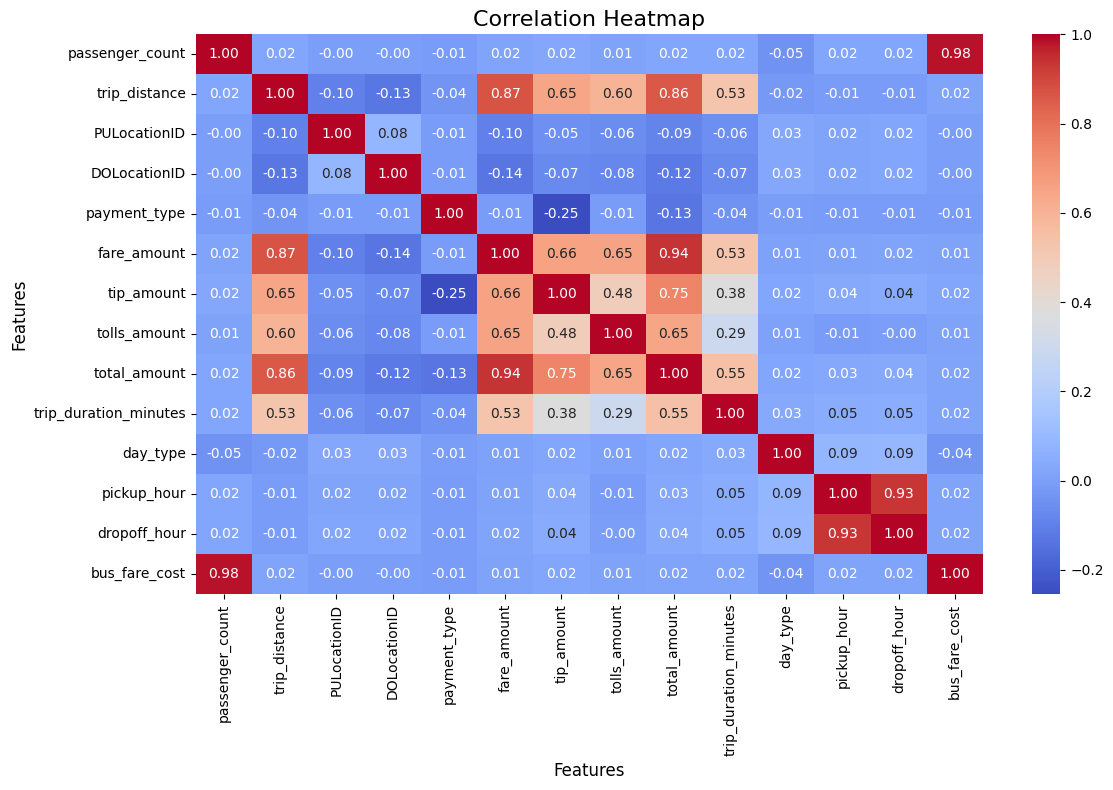

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

Dropping total_amount as it also represents same like fare_amount. And they both are also highly correlated so, dropping total_amount column.

In [ ]:
df = df.drop(['total_amount'], axis=1)

Dropping tip_amount and tolls_amount because they can act as a data leakage indicator for fare_amount

In [ ]:
df = df.drop(['tip_amount', 'tolls_amount'], axis=1)

In [ ]:
df.columns

Index(['passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'trip_duration_minutes', 'day_type',
       'pickup_hour', 'dropoff_hour', 'bus_fare_cost'],
      dtype='object')

Training the model, Predicting fares and comparing pedicted fares and bus fare cost.

RMSE: 5.39
MAE: 2.56
R²: 0.77


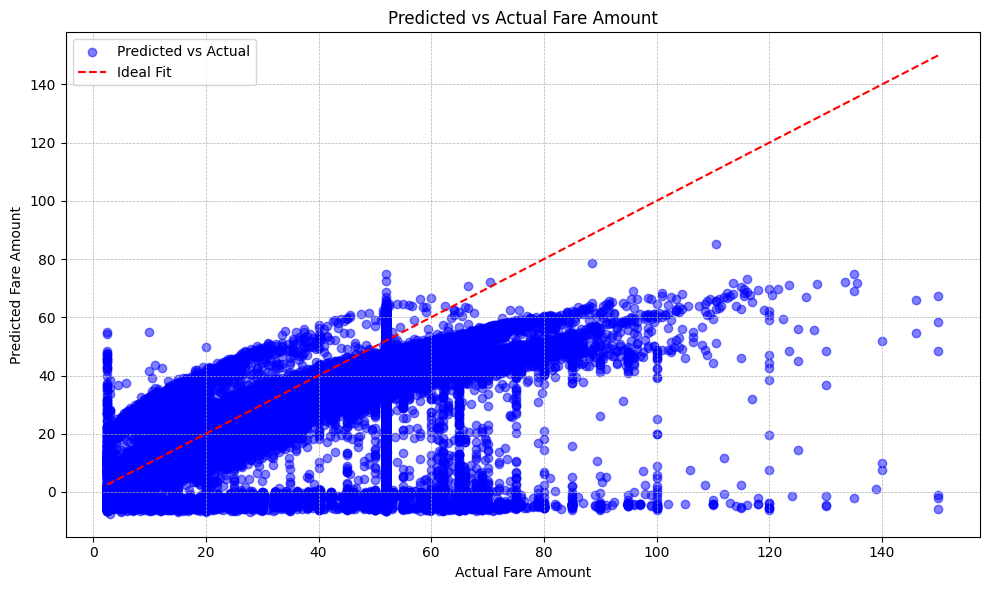

,fare_amount,predicted_fare,bus_fare_cost,savings,savings_exist
0,28.5,31.094954,6.0,25.094954,True
1,4.0,2.444792,6.0,-3.555208,False
2,5.5,6.064516,3.0,3.064516,True
3,18.0,22.127000,9.0,13.127000,True
4,52.0,43.398714,6.0,37.398714,True


In [ ]:
features = df.drop(columns=['fare_amount', 'bus_fare_cost'])
target = df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.title("Predicted vs Actual Fare Amount")
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare Amount")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
df['predicted_fare'] = model.predict(df.drop(columns=['fare_amount', 'bus_fare_cost']))
df['savings'] = df['predicted_fare'] - df['bus_fare_cost']
df['savings_exist'] = df['savings'] > 0
df[['fare_amount', 'predicted_fare', 'bus_fare_cost', 'savings', 'savings_exist']].head()

Now implementing using RandomForestRegressor for prediction and this model is choosen because as it automatically captures interactions between features, it works well with higher level data and it also doesn't amke any assumptions about the data distribution.

Implementing RandomForest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict

RMSE: 2.59
MAE: 0.55
R²: 0.95


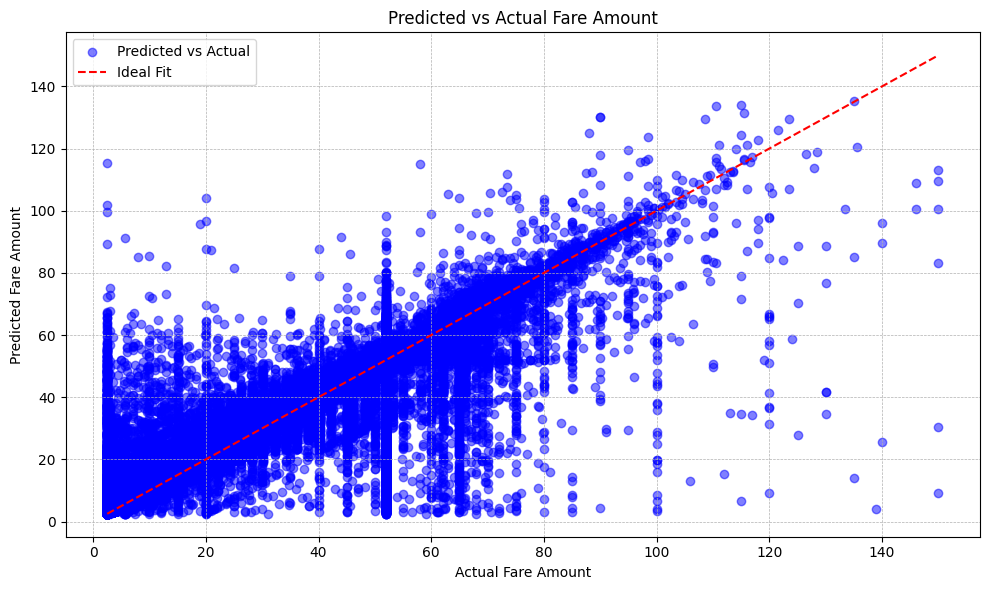

,fare_amount,predicted_fare,bus_fare_cost,savings,savings_exist
0,28.5,29.95,6.0,23.95,True
1,4.0,4.00,6.0,-2.00,False
2,5.5,5.40,3.0,2.40,True
3,18.0,18.20,9.0,9.20,True
4,52.0,52.00,6.0,46.00,True


In [ ]:
features = df.drop(columns=['fare_amount', 'bus_fare_cost'])
target = df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=10, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.title("Predicted vs Actual Fare Amount")
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare Amount")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
df['predicted_fare'] = model.predict(df.drop(columns=['fare_amount', 'bus_fare_cost']))
df['savings'] = df['predicted_fare'] - df['bus_fare_cost']
df['savings_exist'] = df['savings'] > 0
df[['fare_amount', 'predicted_fare', 'bus_fare_cost', 'savings', 'savings_exist']].head()

###### Implementing Ridge Regression.
Ridge regression combines the advantages of linear regression, which is easy to specify and interpret, with the benefits that are obtained by using random forest. The use of L2 regularization in Ridge Regression curtails the size of weights, thereby preventing overfitting and multicollinearity and ensuring linear relationships between features and the output remain intact. Compared to Linear Regression, it is a practical enhancement of R2 score and a reduction of errors, while in many cases, it offers a better generalization than the more complicated model of Random Forest. Predictive accuracy and feature importance are both valued in Ridge Regression and hence it’s preferred.

RMSE: 2.61
MAE: 0.57
R²: 0.95


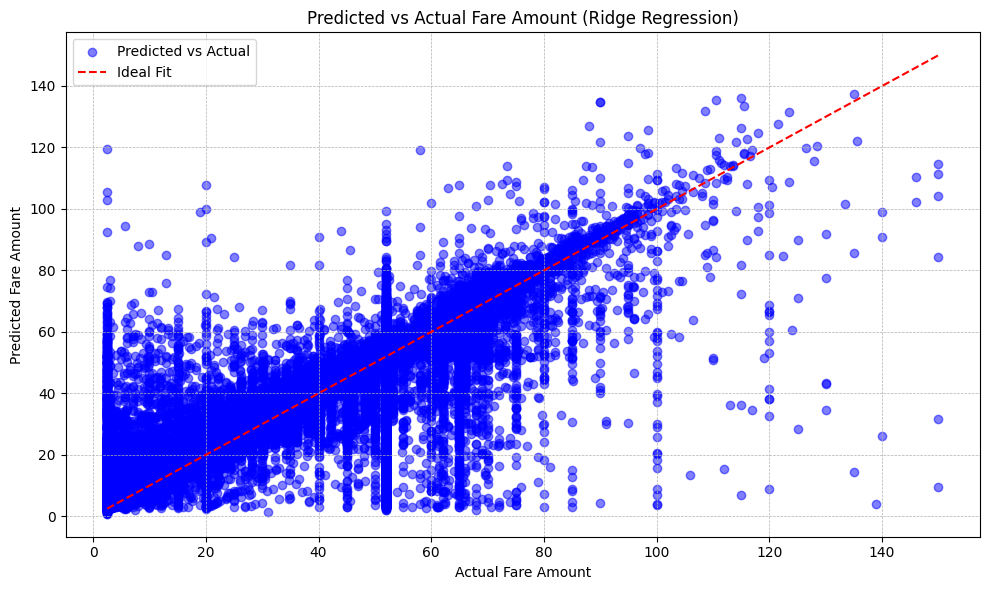

In [ ]:
features = df.drop(columns=['fare_amount', 'bus_fare_cost'])
target = df['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.2f}")
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.title("Predicted vs Actual Fare Amount (Ridge Regression)")
plt.xlabel("Actual Fare Amount")
plt.ylabel("Predicted Fare Amount")
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Comparing metrics of the models

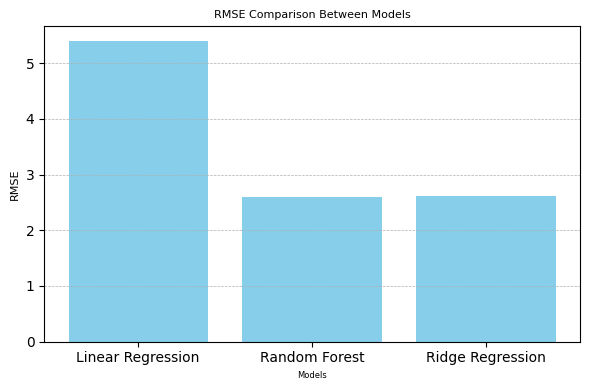

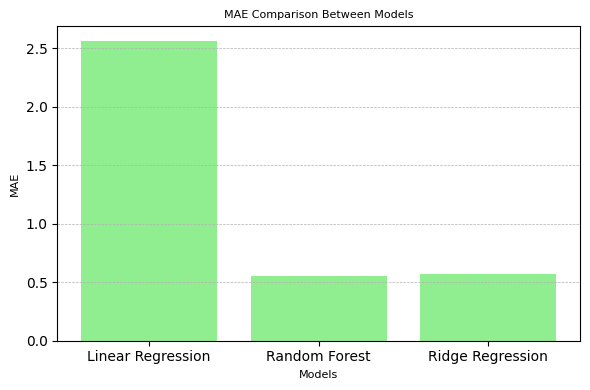

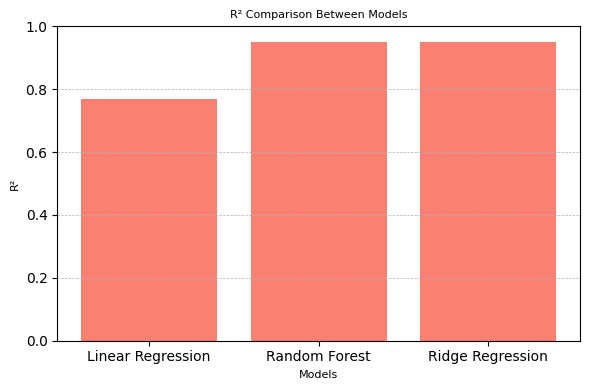

In [ ]:
models = ['Linear Regression', 'Random Forest', 'Ridge Regression']
rmse = [5.39, 2.59, 2.61]
mae = [2.56, 0.55, 0.57]
r2 = [0.77, 0.95, 0.95]
plt.figure(figsize=(6, 4))
plt.bar(models, rmse, color='skyblue')
plt.title('RMSE Comparison Between Models', fontsize=8)
plt.ylabel('RMSE', fontsize=8)
plt.xlabel('Models', fontsize=6)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
plt.figure(figsize=(6,4))
plt.bar(models, mae, color='lightgreen')
plt.title('MAE Comparison Between Models', fontsize=8)
plt.ylabel('MAE', fontsize=8)
plt.xlabel('Models', fontsize=8)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()
plt.figure(figsize=(6, 4))
plt.bar(models, r2, color='salmon')
plt.title('R² Comparison Between Models', fontsize=8)
plt.ylabel('R²', fontsize=8)
plt.xlabel('Models', fontsize=8)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In this case Ridge Regression would be the ideal method as it provides a good compromise between predictive accuracy and interpretability. With R2:0.95, RMSE:2.61 and MAE:0.57, Ridge sees the data structure almost as well as the Random Forest model, but in a more streamlined, linear fashion. Ridge Regression assumes that L2 regularization will prevent the model from becoming overfitted and will efficiently tackle multicollinearity which often exists in the presence of many shared dependent variables. This means ridge regression can be used effectively to establish the response variable effect of each factor feature while still providing very good predictions. In this case, it provides both precision and reasoning, which is quite desirable because interpretation and performance matter.